# Code generating geometrical figures and performing pattern recognition using Deep NN

*Feb. 2020, Marcin Wolter*

In [1]:
'''Trains a simple convnet on the generated set of figures (circle, triangle, square)
'''
from __future__ import print_function

#install KERAS if not there
!pip install keras_sequential_ascii

import matplotlib.pyplot as plt
import matplotlib.pylab as pyl
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation
from keras import backend as K
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras.utils import plot_model
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import metrics

from PIL import Image, ImageDraw

import time
import math



  Created wheel for keras-sequential-ascii: filename=keras_sequential_ascii-0.1.1-py3-none-any.whl size=3061 sha256=eff4b1f7fda264948f5beda7462621d57e47e0be9fbb9a2d21e8b6122f2dbc3d
  Stored in directory: /root/.cache/pip/wheels/68/6d/a2/b41af008be7e9dcf354615163a15aa8d556e6417dae800f340
Successfully built keras-sequential-ascii


Using TensorFlow backend.


Prevent Google Colab from disconnecting

In [2]:
from IPython.display import display, HTML
js = ('<script>function ConnectButton(){ '
           'console.log("Connect pushed"); '
           'document.querySelector("#connect").click()} '
           'setInterval(ConnectButton,3000);</script>')
display(HTML(js))

# **Setup the parameters**

In [3]:
# DNN parameters
batch_size = 128
# number of classes
num_classes = 2
epochs = 256 #12

np.random.seed(2348)

#batch_size_gen = 60000
#batch_size_val = 10000
batch_size_gen = 60000
batch_size_val = 10000

# input image dimensions
img_rows, img_cols = 32, 32
img_shape = (img_rows, img_cols)


#probability of noise and its max. brithness 
prob_noise = 1.0
ampl_noise = 0.3


# figure min and max brithness
fig_min_gray=0.4
fig_max_gray=0.9

#figure sizes
# circle radius
rmin = 0.06
rmax = 0.15
# triangle/rectangle size
dmin = 0.10
dmax = 0.30
# colon / line dot radius in pixels
rpix_min = 0.5
rpix_max = 3

# distortion type
###distortion = "blur"
distortion = "jpeg"
# jpeg_format: jpeg / JPEG2000   - WARNING:  JPEG 2000 does not work on Kaggle!!!!
jpeg_format = "jpeg"
#jpeg_format = 'JPEG2000'
#jpeg_format="jpx"
# distortion - bluring sigma
sigma = (1.8,1.8)
#jpeg compression
jpeg_compression_list = [97, 80, 32, 15, 7, 3]   
jpeg2000_compression_list = [[1],[2],[4],[8],[16],[32]] 


# extrapolate True/False
extrapolate = True
# list of extrapolation factors
extrapolation_list = [0.50, 1., 2.]
###extrapolation_list = [1.]

# Generated 32x32 small image is pasted on a big image, which is a subject of
# graphical operations (jpeg compression, scaling etc). Then it is cropped out
# of it. The big image size is defined here:
bigIm_shape = (512, 512)
smallIm_X = 240
smallIm_Y = 240
# number of images to test the size
n_big = 10

#Remove the saved DNN
! rm best_model.h5

rm: cannot remove 'best_model.h5': No such file or directory


# **Generate noise**

In [4]:
def gen_noise(batch_size_gen=batch_size_gen, img_shape=img_shape, prob_noise=prob_noise):

        batch_events = np.zeros((batch_size_gen, 1, img_shape[0], img_shape[1]))
        for n in range(batch_size_gen):

            for i in range(img_shape[0]):
               for j in range(img_shape[1]):
                 if np.random.random()<prob_noise:
                     batch_events[n,0,i,j]= min(1.,max(0.,ampl_noise*np.random.randn()))


        yield batch_events


#  Generate geometrical figures - circle, triangle, square, colon, line

In [5]:

### generate geometrical figures

def generate_circle(r, x0, y0, img_shape):
    """
    Generate a single circle.
    Parameters:
        r: radius
        x0,y0: position of the circle center
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 10x10 pixels, 1 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.ellipse((x0-r, y0-r, x0+r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255
    
    #print(x)
    return x

In [6]:
def generate_square(d, x0, y0, angle, img_shape):
    """
    Generate a square.
    Parameters:
        d: size
        x0,y0: position of the square center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.rectangle((x0-d/2, y0-d/2, x0+d/2, y0+d/2), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255

      
    #print(x)
    return x




In [7]:
def generate_triangle(d, x0, y0, angle, img_shape):
    """
    Generate a triangle.
    Parameters:
        d: size 
        x0,y0: position of the triangle center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel grayscale
    draw = ImageDraw.Draw(image)
    dd = d/math.sqrt(3)
    draw.polygon(((x0-d/2, y0-dd/2), (x0+d/2, y0-dd/2), (x0,y0+dd)), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255.
    
    #print(x)
    return x



In [8]:
def generate_line(r, x0, y0, angle, img_shape):
    """
    Generate a line.
    Parameters:
        r: width, length = 5*r
        x0,y0: position of the line center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.rectangle((x0-2.5*r, y0-r, x0+2.5*r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255

      
    #print(x)
    return x



In [9]:
def generate_colon(r, x0, y0, angle, img_shape):
    """
    Generate a colon.
    Parameters:
        r: dot radius
        x0,y0: position of the colon center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.ellipse((x0-1.5*r-r, y0-r, x0-1.5*r+r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    draw.ellipse((x0+1.5*r-r, y0-r, x0+1.5*r+r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255

      
    #print(x)
    return x



In [10]:


# generate a random number
def rand_interval(a = 0., b = 1.):
   rnd = a + (b-a)*np.random.random()
   return rnd


# **Random figure generator**

In [11]:
# Generator for random figures
# Each image contains exactly one object (circle, triangle, square)
def gen_n_figures(batch_size_gen=batch_size_gen, img_shape=img_shape):

        batch_events  = np.zeros((batch_size_gen, 1, img_shape[0], img_shape[1]))
        batch_targets =-np.ones((batch_size_gen, 1, 1 ))

        for n in range(batch_size_gen):
            
            k = np.random.randint(0,num_classes)

            
            rpix = rand_interval(rpix_min,rpix_max)
            r = rand_interval(img_cols*rmin, img_cols*rmax)
            d = rand_interval(img_cols*dmin, img_cols*dmax) 
            l = rand_interval(img_cols*dmin, img_cols*dmax)
            x0 = rand_interval(0.33*img_cols, 0.66*img_cols)       
            y0 = rand_interval(0.33*img_rows, 0.66*img_rows)     
            alpha = 360.*np.random.random()  

            if k == 0:
               batch_events[n,0] = generate_colon(rpix, x0, y0, alpha, img_shape)
            elif k == 1:
               batch_events[n,0] = generate_line(rpix, x0, y0, alpha, img_shape)  
            elif k == 2:                
               batch_events[n,0] = generate_circle(r, x0, y0, img_shape)
            elif k == 3:
               batch_events[n,0] = generate_square(d, x0, y0, alpha, img_shape)
            elif k == 4:
               batch_events[n,0] = generate_triangle(l, x0, y0, alpha, img_shape)                             
            else:
               print("Wrong figure id!!!")
            batch_targets[n,0] = k
            


        yield batch_events, batch_targets



# **Distort an image** 
Distortion might be either bluring or a conversion to jpeg and back.

In [12]:
# Distort images
from scipy import ndimage
#PILlow package
from PIL import Image
from io import BytesIO
import scipy.misc

def distort_n_figures(images, jpeg_compression, distortion=distortion, img_shape=img_shape, sigma = sigma):
  
  if (distortion == "blur"):
    images_distorted = np.zeros((len(images), 1, img_shape[0], img_shape[1]))
    for n in range(len(images)):
     
    
      images_distorted[n,0] = ndimage.gaussian_filter(255.*images[n,0], sigma=sigma)/255.
#      images_distorted[n,0] = images[n,0]

    return -1, images_distorted

  elif (distortion == "jpeg"):
    images_distorted = np.zeros((len(images), 1, img_shape[0], img_shape[1]))
    # create a BIG image just with noise
    array_big = next(gen_noise(1, bigIm_shape ))
    image_file_size = 0

    #n_big = len(images)

    for n in range(len(images)):
        # convert to jpeg and than back
        if  (n+1)%10000==0:
           print("Distorting image ",n)

        buffer = BytesIO()
        auxIm = Image.fromarray((255.*images[n,0]).astype(np.uint8))

        if n < n_big:
           #print("array_big.shape ",array_big[0,0].shape)
           bigIm = Image.fromarray((255.*array_big[0,0]).astype(np.uint8))
           #print("bigIm.size ",bigIm.size)
           #print("auxIm.size ",auxIm.size)
           #paste auxIm into the middle of bigIm
           bigIm.paste(auxIm,(smallIm_X,smallIm_Y))
           auxIm = bigIm
        #print("auxIm.size from bigIm ",auxIm.size)

        if jpeg_format == 'jpeg':
           auxIm.save(buffer, format=jpeg_format, quality=jpeg_compression)
        elif jpeg_format == 'JPEG2000':
           auxIm.save(buffer, format=jpeg_format, quality_mode='rates', quality_layers=jpeg_compression, irreversible=True)  
        else:
           print("Unknown format %s" % jpeg_format)    

        if n < n_big:
           image_file_size = image_file_size + buffer.tell()

  
        buffer.seek(0)
        auxIm = Image.open(buffer)

        # resize image and then resize back to the original size using BICUBIC
        if (extrapolation_factor != 1.):
           width, height = auxIm.size
           auxIm = auxIm.resize((int(extrapolation_factor*width),int(extrapolation_factor*height)),resample=Image.BICUBIC)
           #print("image size ",auxIm.size)
           auxIm = auxIm.resize((width,height),resample=Image.BICUBIC)
        
        # crop original image from the big image
        if n < n_big:
           auxIm = auxIm.crop((smallIm_X,smallIm_Y,smallIm_X+img_cols,smallIm_Y+img_rows))
        #print("Final image size ",auxIm.size)

        # add image to the array of distorted images
        images_distorted[n,0] = np.array(auxIm) / 255.  
 
    average_size = image_file_size/n_big

    return average_size, images_distorted

  else:
    return -1, images  

## **Plot some images**

In [13]:
def plot_images(plot_size=6):

  class_names = ['colon','line','circle','square','triangle']

  offset = max(0, min(batch_size_gen-plot_size*plot_size, np.random.randint(0,batch_size_gen/2)))
  plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.90, wspace=0.20, hspace=0.40)
  for n in range(min(plot_size*plot_size,len(xx_train))):
    ax = plt.subplot(plot_size, plot_size, n+1)
    ax.imshow(xx_train[n+offset,0], cmap='gray', vmin=0, vmax=1)
    ax.set_title(class_names[int(yy_train[n+offset,0])])
    ax.axis('off')

  plt.show()
  #plt.savefig('event.png')
  #plt.clf()


#plotting results of classification
def plot_results(plot_size=6):
  
  class_names = ['colon','line','circle','square','triangle']
  YY_pred = saved_model.predict(xx_val, verbose=2)
  
  offset = max(0, min(len(YY_pred)-plot_size*plot_size, np.random.randint(0,len(YY_pred)/2)))

  plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.90, wspace=0.20, hspace=0.40)
  for i in range(int(min(plot_size/2,len(YY_pred)/plot_size))):
    for n in range(int(min(plot_size,len(YY_pred)))):
      ax = plt.subplot(plot_size,plot_size,plot_size*2*i+n+1 )
      ax.imshow(xx_val[plot_size*i+n+offset,0], cmap='gray', vmin=0, vmax=1)
      ax.axis('off')

    for n in range(min(plot_size,len(YY_pred))):
      ax = plt.subplot(plot_size,plot_size,plot_size*2*i+plot_size+n+1)
      x = np.arange(num_classes)
      ax.bar(x, height = YY_pred[plot_size*i+n+offset,0], tick_label = class_names[0:num_classes]) 
      ax.axis('off')
#      ax.set_title(class_names[int(np.argmax(YY_pred,axis=2)[plot_size*i+n+offset])])
      ax.set_title(class_names[int(np.argmax(yy_val,axis=2)[plot_size*i+n+offset])])
#      print("yy_val",np.argmax(yy_val,axis=2))
#      print("YY_pred",np.argmax(YY_pred,axis=2))
  
  plt.show()
  #plt.savefig('event.png')
  #plt.clf()


# **Generate training and test data**

In [14]:
def generate_datasets():

   #generate training and validation dataset
   xx_train, yy_train = next(gen_n_figures(batch_size_gen, img_shape))
   xx_test, yy_test   = next(gen_n_figures(batch_size_val, img_shape))
   xx_val, yy_val     = next(gen_n_figures(batch_size_val, img_shape))

   print("Figures created")

   # add noise
   xx_train = xx_train + next(gen_noise(batch_size_gen, img_shape))
   xx_test  = xx_test  + next(gen_noise(batch_size_val, img_shape))
   xx_val   = xx_val  + next(gen_noise(batch_size_val, img_shape))

   print("Noise added")

   #and distort an image
   av_size_train, xx_train = distort_n_figures(xx_train, jpeg_compression)
   av_size_test, xx_test  = distort_n_figures(xx_test, jpeg_compression)
   av_size_val, xx_val   = distort_n_figures(xx_val, jpeg_compression)

   print("Images distorted")
   
   #and clip to get maximum 1
   xx_train = np.clip(xx_train, 0, 1)
   xx_test  = np.clip(xx_test, 0, 1)
   xx_val   = np.clip(xx_val, 0, 1)

 
   return xx_train, xx_test, xx_val, yy_train, yy_test, yy_val, av_size_train

# **Draw confussion matrix**

In [15]:
# Confusion matrix result

def draw_confussion_matrix():

   from sklearn.metrics import classification_report, confusion_matrix
   YY_pred = saved_model.predict(xx_val, verbose=2)
   yy_pred = np.argmax(YY_pred, axis=2)

   yy_test2 = np.argmax(yy_test, axis=2)



   #confusion matrix
   cm = confusion_matrix(np.argmax(yy_val,axis=2),yy_pred)
   print(cm)

   # Visualizing of confusion matrix
   import seaborn as sn
   import pandas  as pd


   df_cm = pd.DataFrame(cm, range(num_classes),range(num_classes))
   plt.figure(figsize = (10,7))
   sn.set(font_scale=1.4)#for label size
   sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
   plt.show()



# **Plot training results**

In [16]:

# Plots for training and testing process: loss and accuracy
def plot_training_results(cnn):

   n_epochs = len(cnn.history['loss'])

   plt.figure(0)
   plt.plot(cnn.history['categorical_accuracy'],'r')
   plt.plot(cnn.history['val_categorical_accuracy'],'g')
   plt.xticks(np.arange(0, n_epochs, 10.0))
   plt.rcParams['figure.figsize'] = (8, 6)
   plt.xlabel("Num of Epochs")
   plt.ylabel("Accuracy")
   plt.title("Training Cat_Accuracy vs Validation Cat_Accuracy")
   plt.legend(['train','validation'])

   plt.figure(1)
   plt.plot(cnn.history['loss'],'r')
   plt.plot(cnn.history['val_loss'],'g')
   plt.xticks(np.arange(0, n_epochs, 10.0))
   plt.rcParams['figure.figsize'] = (8, 6)
   plt.xlabel("Num of Epochs")
   plt.ylabel("Loss")
   plt.title("Training Loss vs Validation Loss")
   plt.legend(['train','validation'])
   plt.show()





# **Define Deep Neural Network**

In [17]:
# Define Model

def base_model():

    model = Sequential()
    input_shape=(1,img_rows,img_cols)

    model.add(Reshape((img_rows,img_cols,1),input_shape=input_shape))


    model.add(Conv2D(img_rows, (3, 3), padding='same', activation='relu'))
    model.add(Dropout(rate = 0.2))

    model.add(Conv2D(img_rows,(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(2*img_rows,(3,3),padding='same',activation='relu'))
    model.add(Dropout(rate = 0.2))

    model.add(Conv2D(2*img_rows,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(4*img_rows,(3,3),padding='same',activation='relu'))
    model.add(Dropout(rate = 0.2))

    model.add(Conv2D(4*img_rows,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(rate = 0.2))
    model.add(Dense(32*img_rows,activation='relu',kernel_constraint=maxnorm(3))) #1024
    model.add(Dropout(rate = 0.3))
    model.add(Dense(32*img_rows,activation='relu',kernel_constraint=maxnorm(3))) #1024
    model.add(Dropout(rate = 0.3))


    model.add(Dense(num_classes, activation='softmax'))

    model.add(Reshape((1,num_classes),input_shape=(num_classes,)))

#    sgd = SGD(lr = 0.1, decay=1e-6, nesterov=True)
#    sgd = SGD(lr = 0.01, decay=1e-6, nesterov=True)

# Compile model

    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=[metrics.categorical_accuracy])   # 'accuracy'

    return model



# **Visualize the network**

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)       

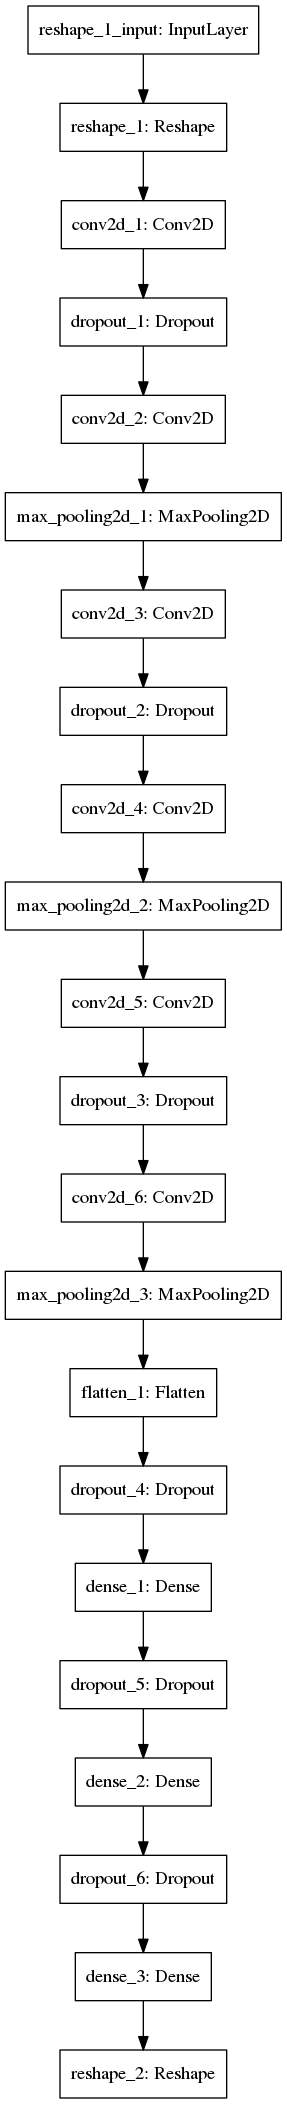

In [18]:

# Vizualizing model structure
# Model summary (ascii)
cnn_n = base_model()

cnn_n.summary()

# Model printout (ascii)
sequential_model_to_ascii_printout(cnn_n)

# Plotting model in graphical mode
plot_model(cnn_n)   ###, to_file='model.png')  ###, show_shapes=True

# **Train DNN** and display results for various jpeg qualities given in jpeg_quality_list

 
 
Extrapolation factor =  0.5
JPEG compression =  97
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


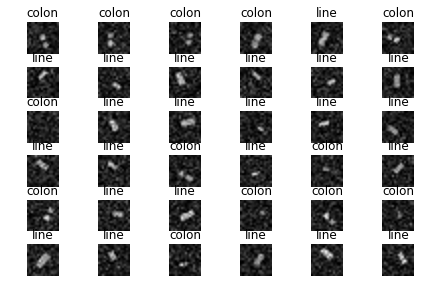

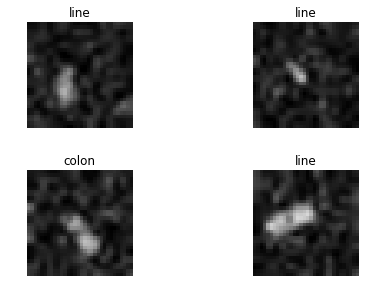

yy_train  (60000, 1, 2)
No saved model, training a new one.

Epoch 00001: val_categorical_accuracy improved from -inf to 0.82720, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.82720 to 0.85110, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy improved from 0.85110 to 0.85850, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy did not improve from 0.85850

Epoch 00005: val_categorical_accuracy did not improve from 0.85850

Epoch 00006: val_categorical_accuracy improved from 0.85850 to 0.86230, saving model to best_model.h5

Epoch 00007: val_categorical_accuracy improved from 0.86230 to 0.86270, saving model to best_model.h5

Epoch 00008: val_categorical_accuracy did not improve from 0.86270

Epoch 00009: val_categorical_accuracy improved from 0.86270 to 0.86650, saving model to best_model.h5

Epoch 00010: val_categorical_accuracy did not improve from 0.86650

Epoch 00011: val_categorical_accuracy did not improv

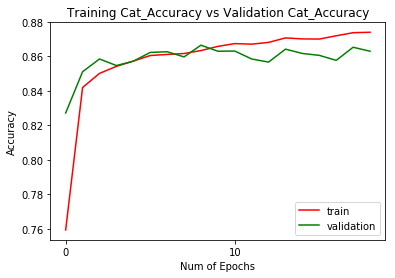

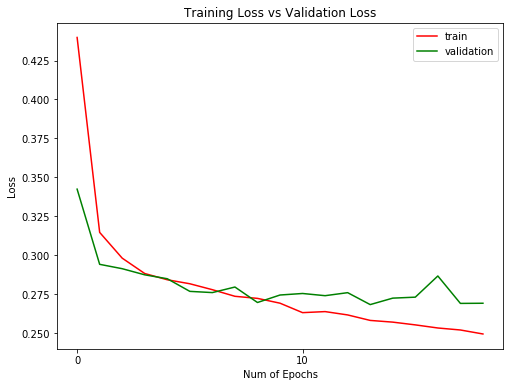

[[4116  907]
 [ 479 4498]]


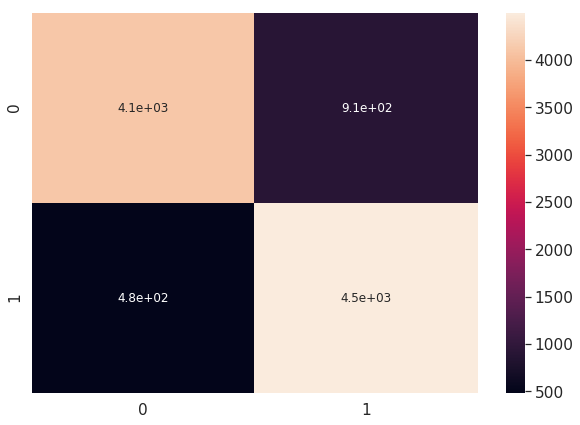

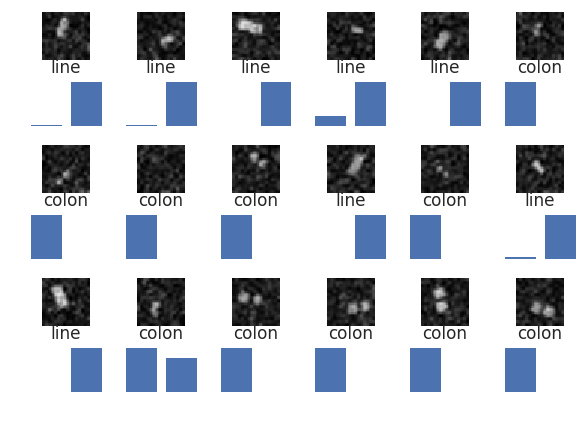

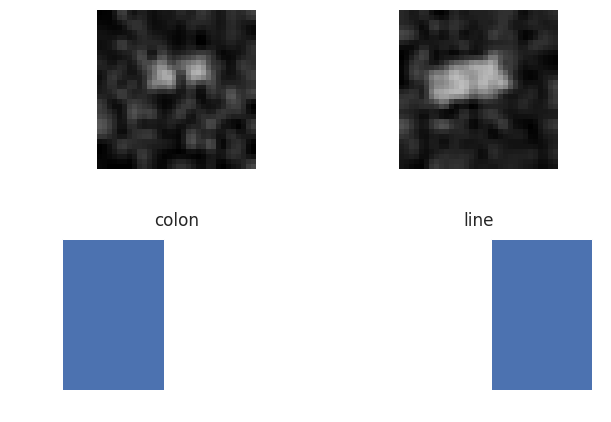

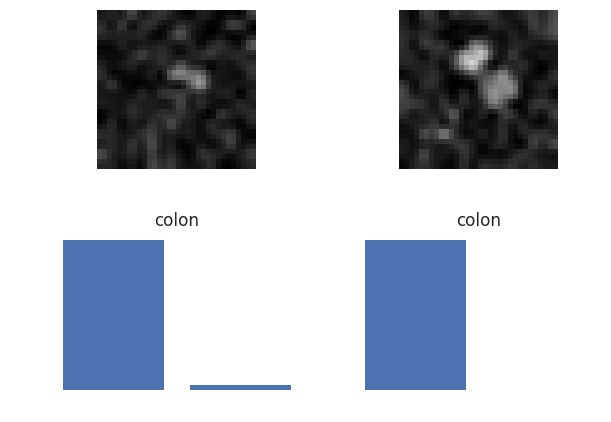

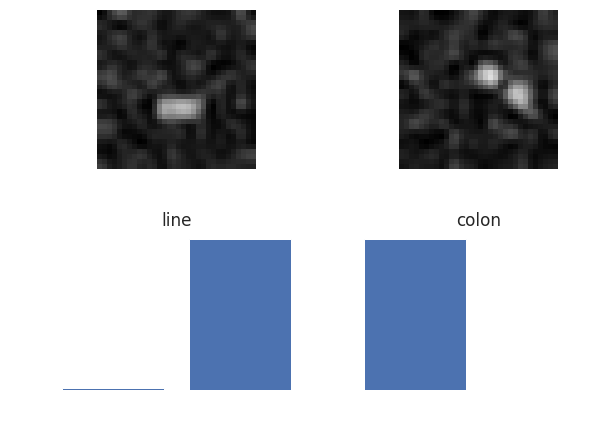

 
 
Extrapolation factor =  0.5
JPEG compression =  80
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


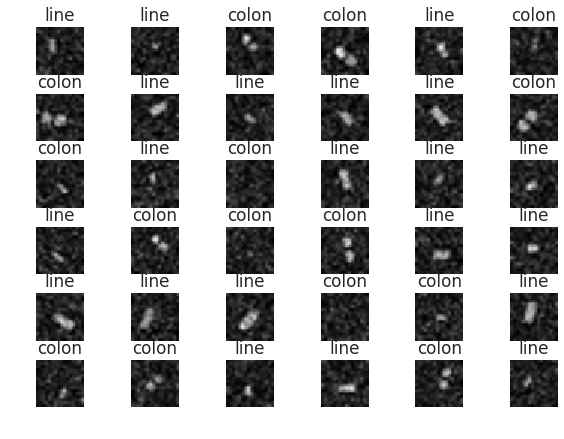

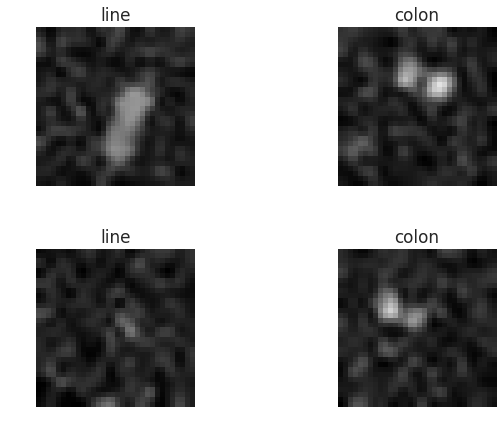

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.86610, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.86610

Epoch 00003: val_categorical_accuracy did not improve from 0.86610

Epoch 00004: val_categorical_accuracy did not improve from 0.86610

Epoch 00005: val_categorical_accuracy improved from 0.86610 to 0.86640, saving model to best_model.h5

Epoch 00006: val_categorical_accuracy improved from 0.86640 to 0.86820, saving model to best_model.h5

Epoch 00007: val_categorical_accuracy improved from 0.86820 to 0.86830, saving model to best_model.h5

Epoch 00008: val_categorical_accuracy did not improve from 0.86830

Epoch 00009: val_categorical_accuracy did not improve from 0.86830

Epoch 00010: val_categorical_accuracy did not improve from 0.86830

Epoch 00011: val_categorical_accuracy did not improve from 0.86830

Epoch 00012: val_categorical_accuracy improved from 0.86830 to 0.87060, saving model to be

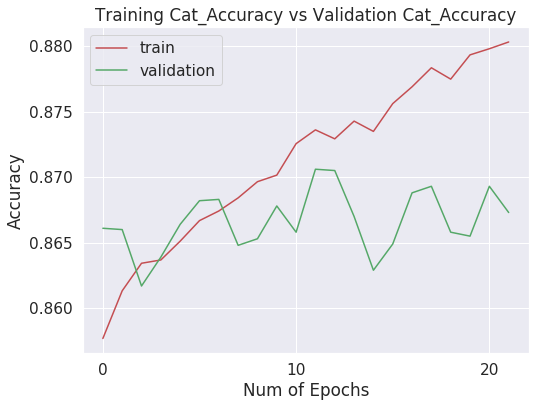

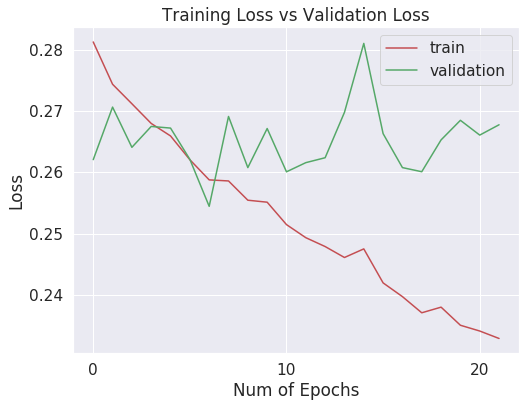

[[4175  845]
 [ 499 4481]]


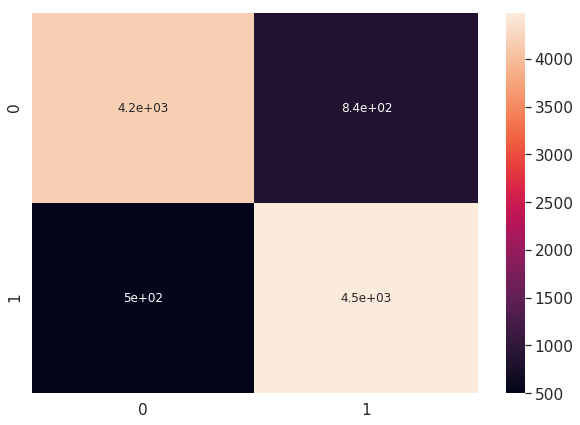

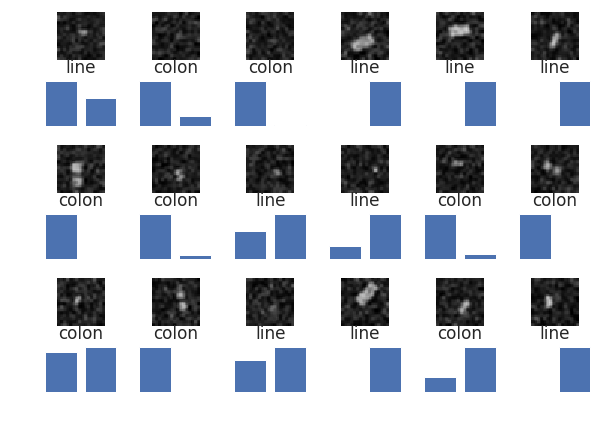

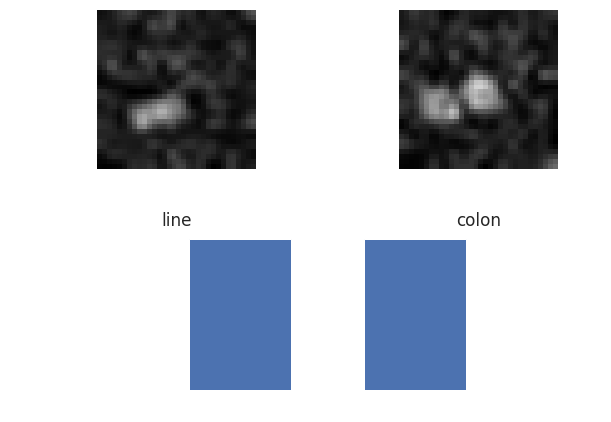

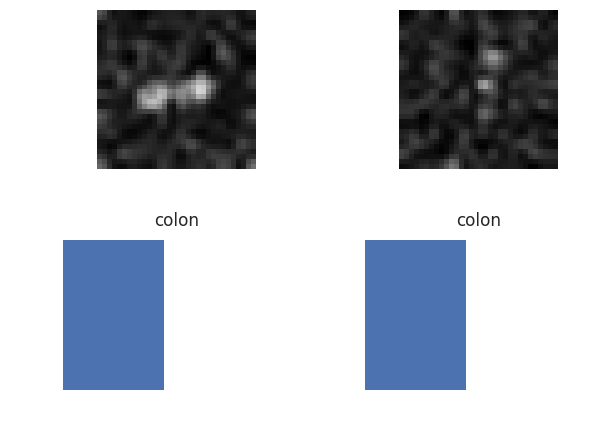

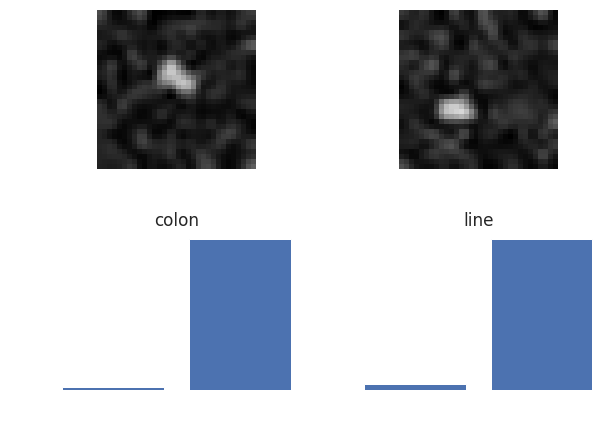

 
 
Extrapolation factor =  0.5
JPEG compression =  32
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


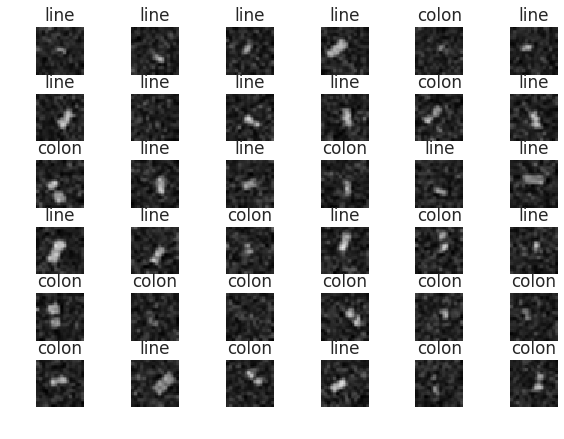

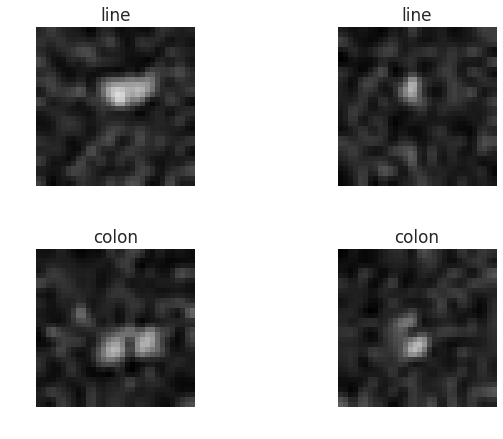

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.86660, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.86660

Epoch 00003: val_categorical_accuracy did not improve from 0.86660

Epoch 00004: val_categorical_accuracy did not improve from 0.86660

Epoch 00005: val_categorical_accuracy improved from 0.86660 to 0.86820, saving model to best_model.h5

Epoch 00006: val_categorical_accuracy did not improve from 0.86820

Epoch 00007: val_categorical_accuracy did not improve from 0.86820

Epoch 00008: val_categorical_accuracy did not improve from 0.86820

Epoch 00009: val_categorical_accuracy did not improve from 0.86820

Epoch 00010: val_categorical_accuracy did not improve from 0.86820

Epoch 00011: val_categorical_accuracy did not improve from 0.86820

Epoch 00012: val_categorical_accuracy did not improve from 0.86820

Epoch 00013: val_categorical_accuracy did not improve from 0.86820

Epoch 00014: val_categor

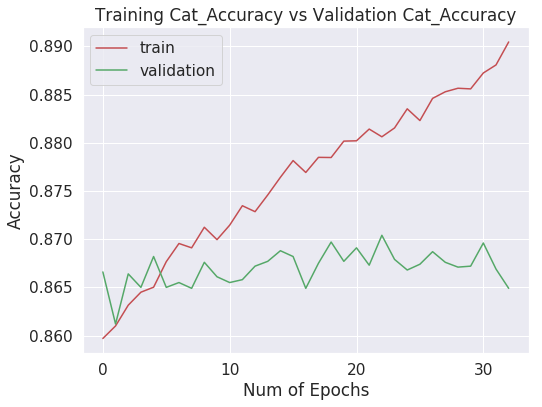

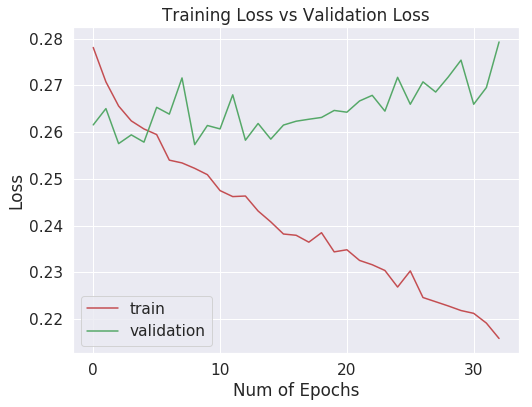

[[4214  806]
 [ 535 4445]]


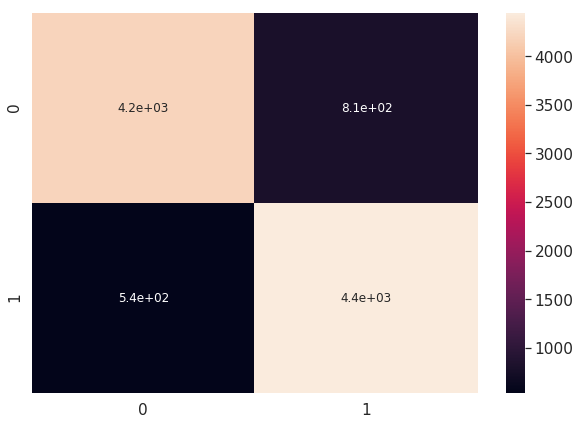

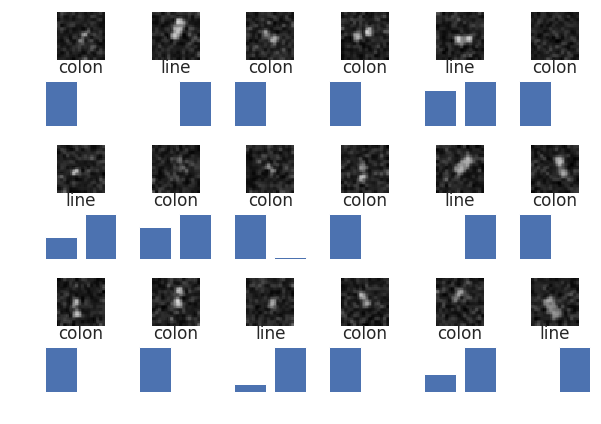

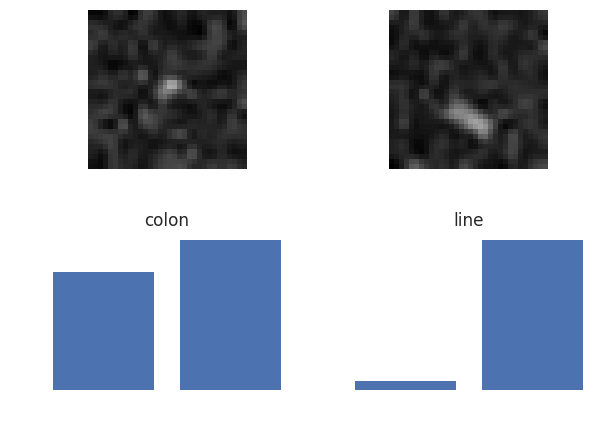

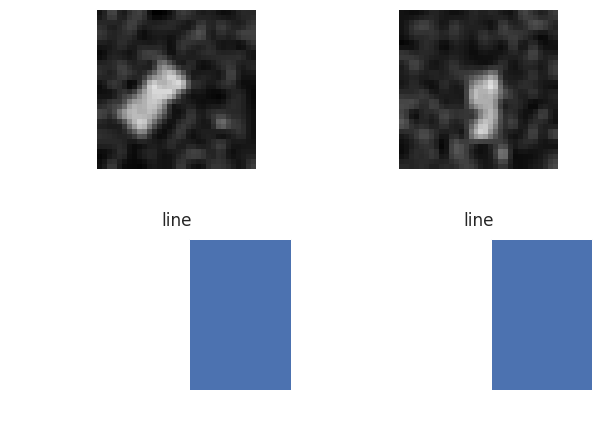

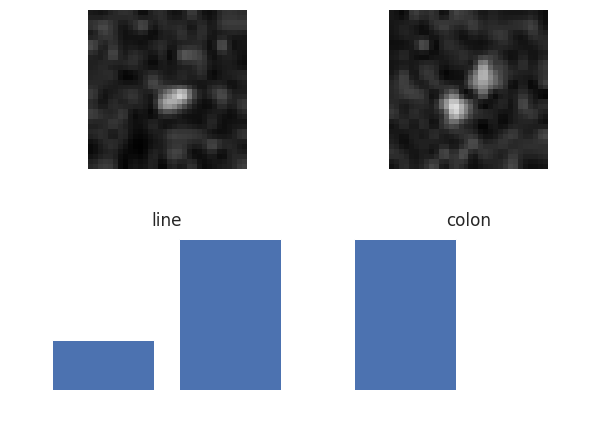

 
 
Extrapolation factor =  0.5
JPEG compression =  15
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


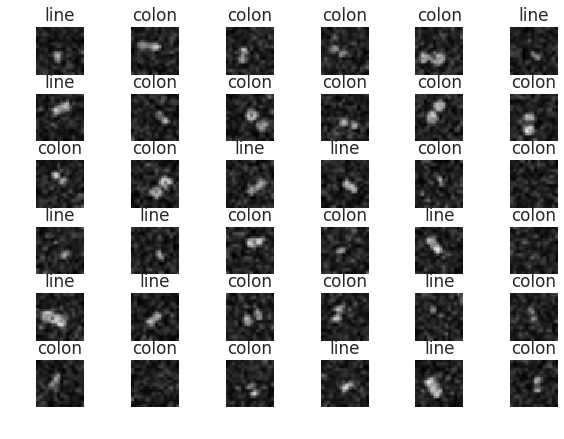

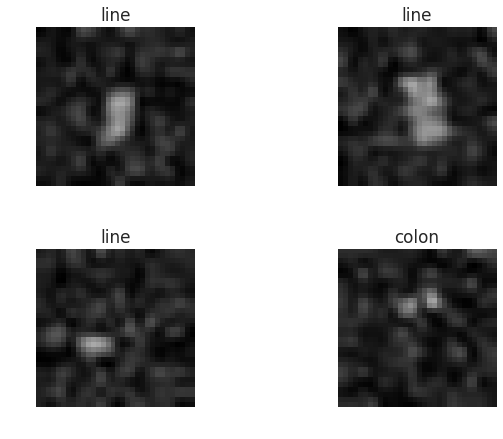

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.86830, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.86830

Epoch 00003: val_categorical_accuracy improved from 0.86830 to 0.86950, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy did not improve from 0.86950

Epoch 00005: val_categorical_accuracy did not improve from 0.86950

Epoch 00006: val_categorical_accuracy did not improve from 0.86950

Epoch 00007: val_categorical_accuracy did not improve from 0.86950

Epoch 00008: val_categorical_accuracy did not improve from 0.86950

Epoch 00009: val_categorical_accuracy improved from 0.86950 to 0.87100, saving model to best_model.h5

Epoch 00010: val_categorical_accuracy did not improve from 0.87100

Epoch 00011: val_categorical_accuracy did not improve from 0.87100

Epoch 00012: val_categorical_accuracy did not improve from 0.87100

Epoch 00013: val_categorical_accuracy did not improve fro

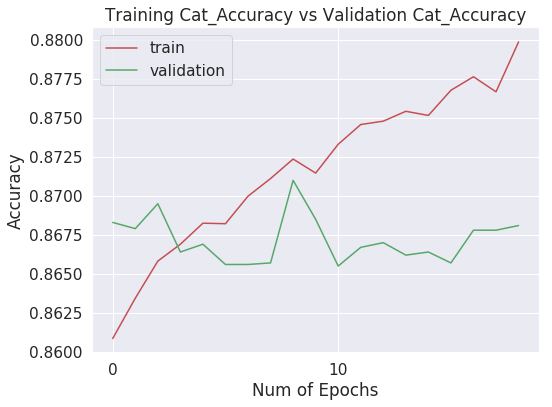

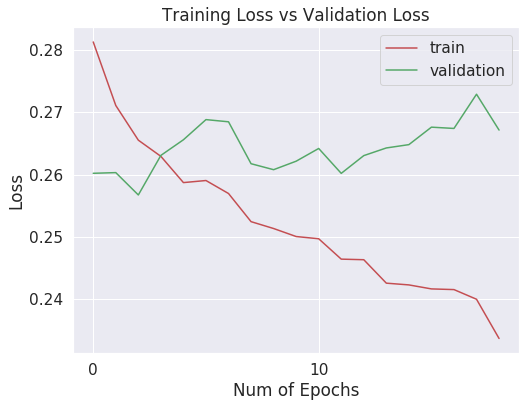

[[3886 1088]
 [ 302 4724]]


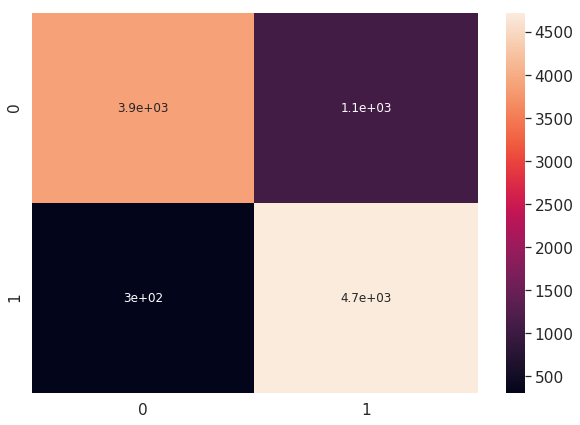

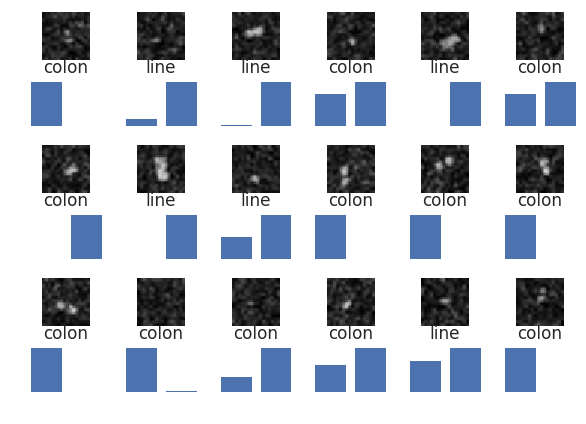

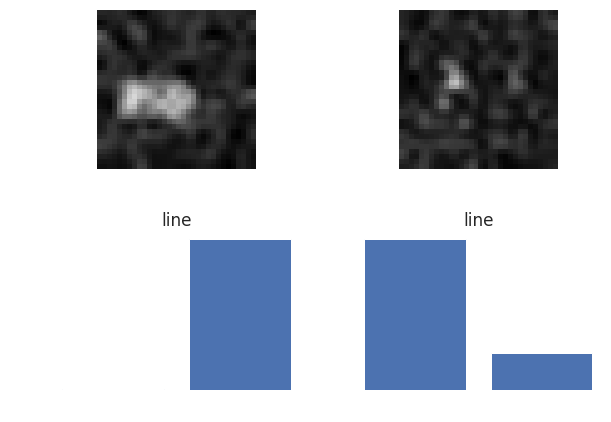

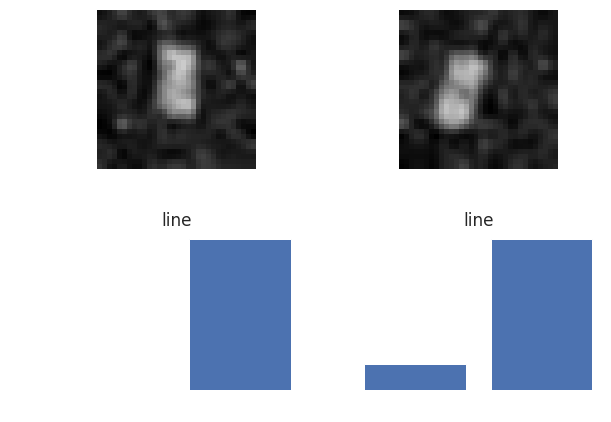

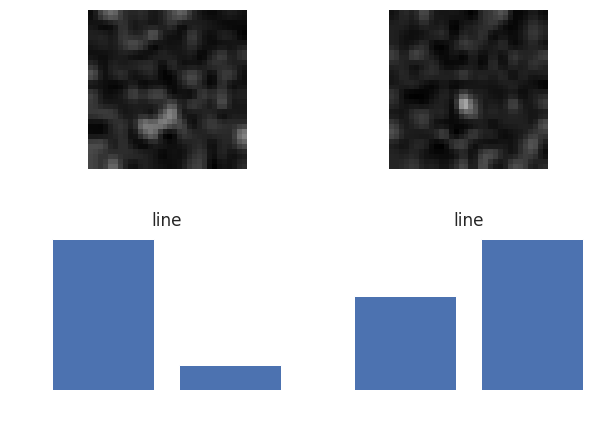

 
 
Extrapolation factor =  0.5
JPEG compression =  7
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


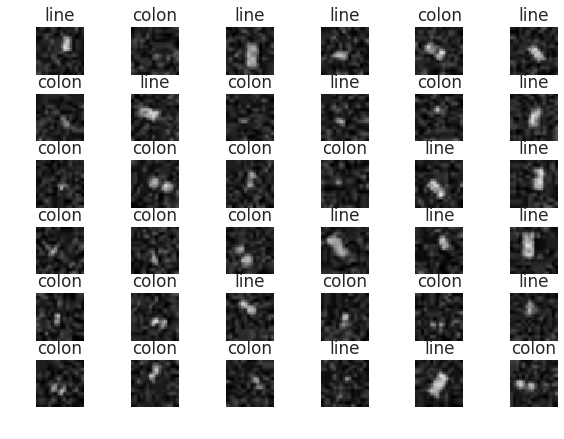

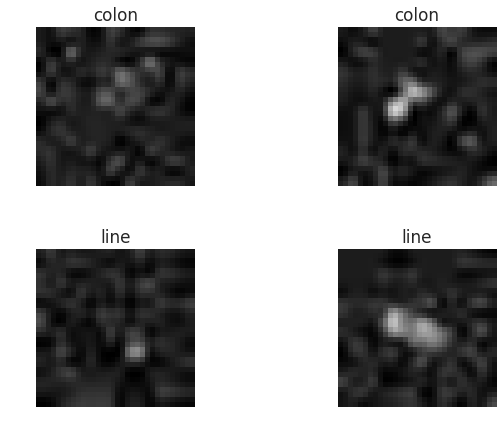

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.85410, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.85410

Epoch 00003: val_categorical_accuracy improved from 0.85410 to 0.85880, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy did not improve from 0.85880

Epoch 00005: val_categorical_accuracy did not improve from 0.85880

Epoch 00006: val_categorical_accuracy did not improve from 0.85880

Epoch 00007: val_categorical_accuracy did not improve from 0.85880

Epoch 00008: val_categorical_accuracy did not improve from 0.85880

Epoch 00009: val_categorical_accuracy did not improve from 0.85880

Epoch 00010: val_categorical_accuracy did not improve from 0.85880

Epoch 00011: val_categorical_accuracy did not improve from 0.85880

Epoch 00012: val_categorical_accuracy did not improve from 0.85880

Epoch 00013: val_categorical_accuracy did not improve from 0.85880
Epoch 00013: early stoppi

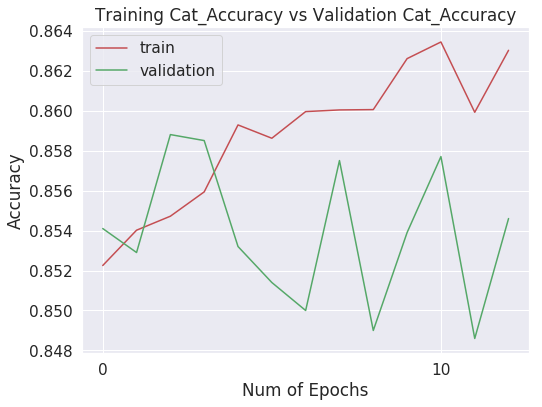

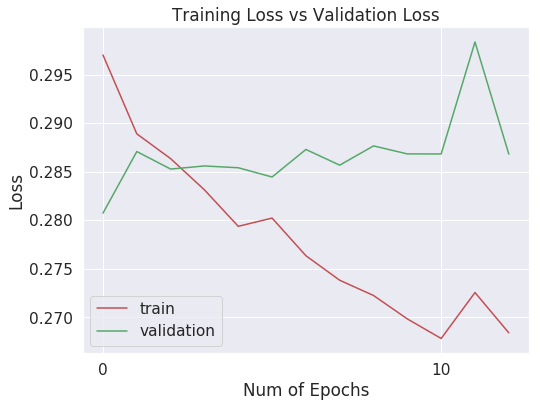

[[3969 1019]
 [ 444 4568]]


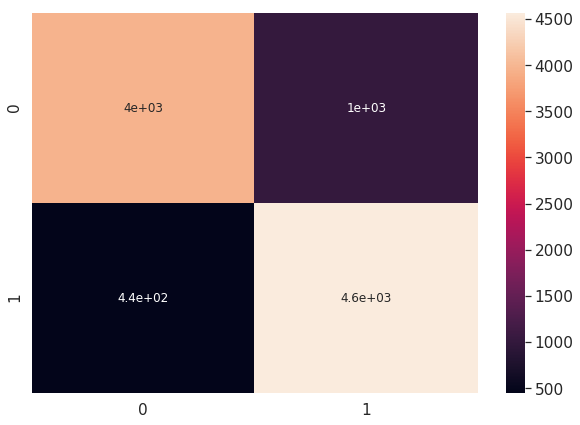

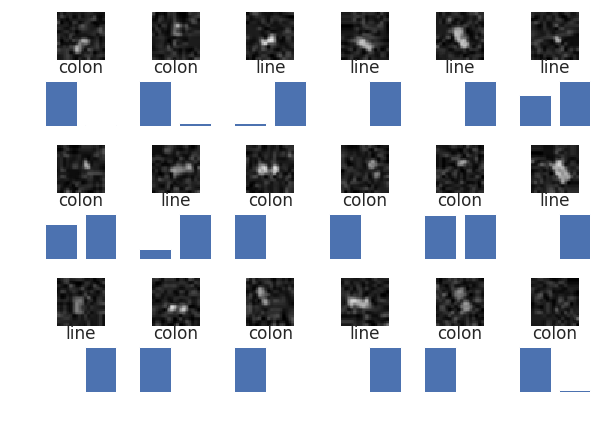

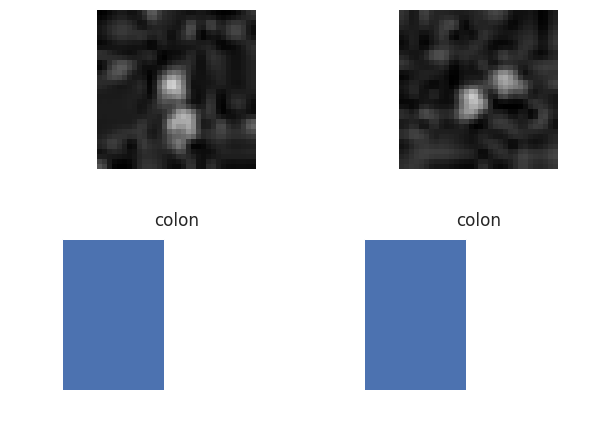

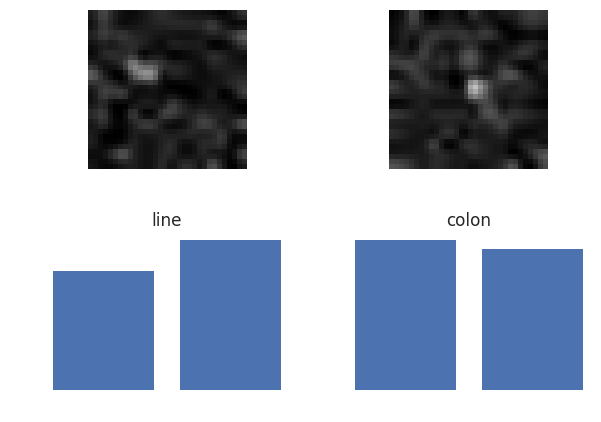

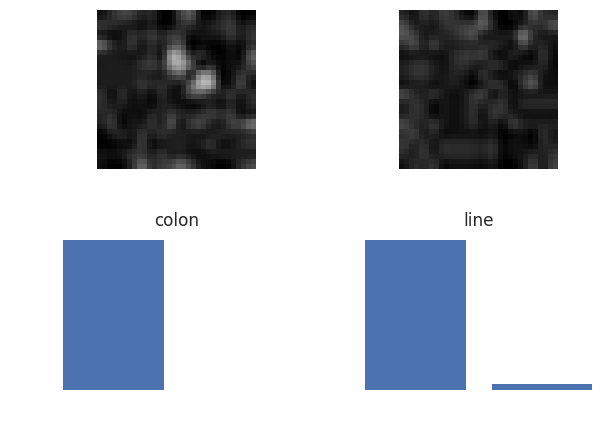

 
 
Extrapolation factor =  0.5
JPEG compression =  3
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


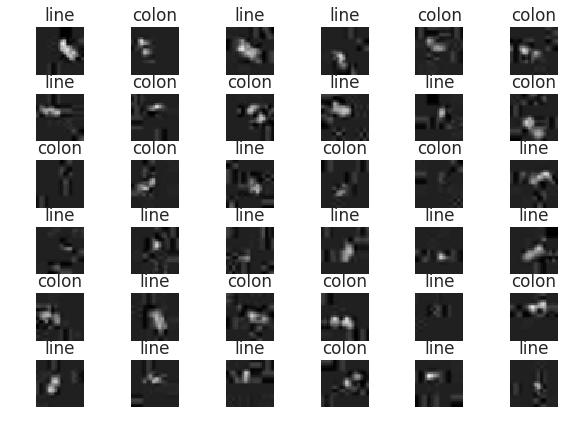

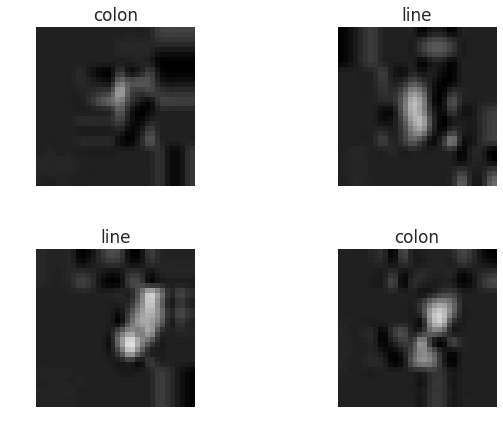

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.80130, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.80130 to 0.80430, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy improved from 0.80430 to 0.80920, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy did not improve from 0.80920

Epoch 00005: val_categorical_accuracy did not improve from 0.80920

Epoch 00006: val_categorical_accuracy did not improve from 0.80920

Epoch 00007: val_categorical_accuracy did not improve from 0.80920

Epoch 00008: val_categorical_accuracy did not improve from 0.80920

Epoch 00009: val_categorical_accuracy did not improve from 0.80920

Epoch 00010: val_categorical_accuracy did not improve from 0.80920

Epoch 00011: val_categorical_accuracy did not improve from 0.80920

Epoch 00012: val_categorical_accuracy did not improve from 0.80920

Epoch 00013: val_categorical_accuracy did not improve fro

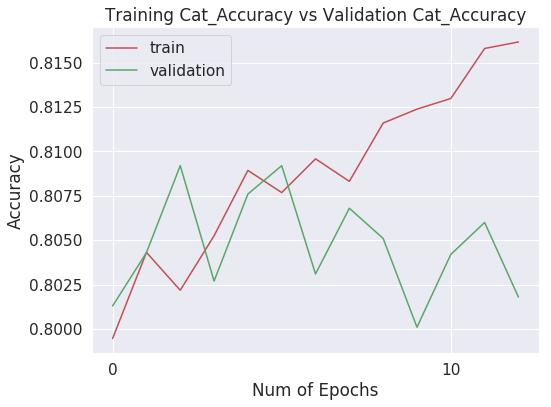

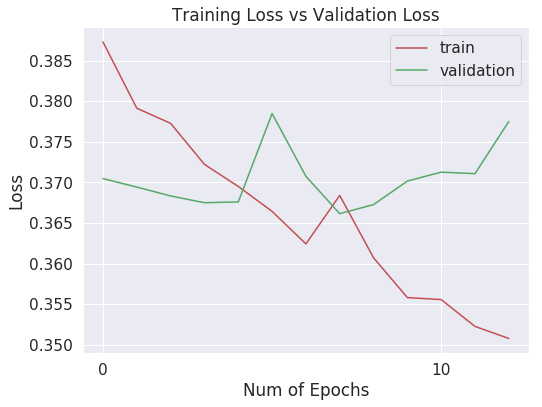

[[3766 1169]
 [ 734 4331]]


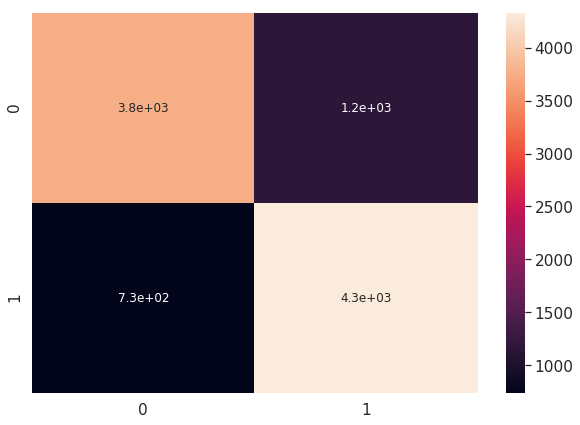

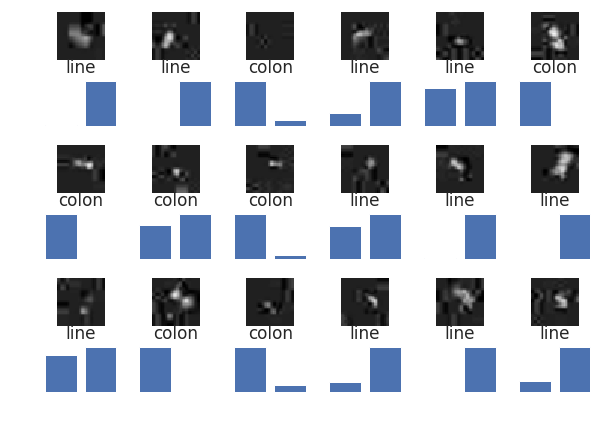

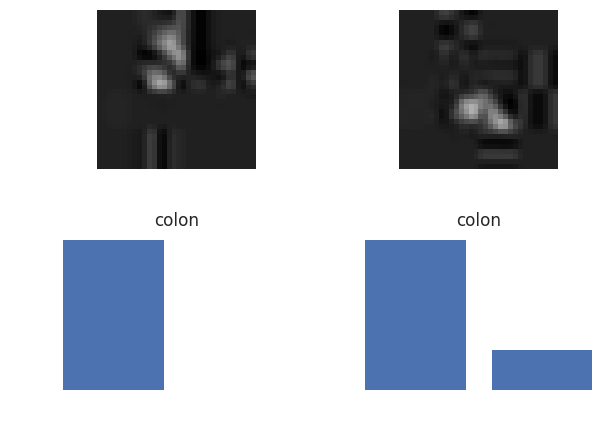

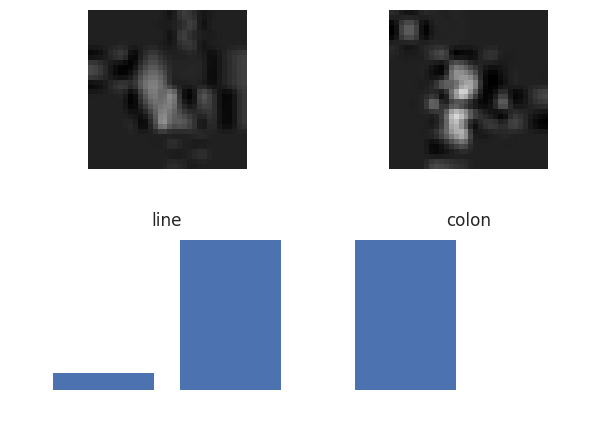

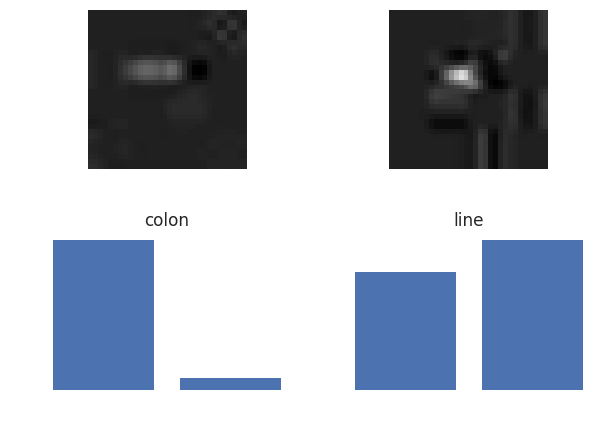

 
 
Extrapolation factor =  1.0
JPEG compression =  97
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


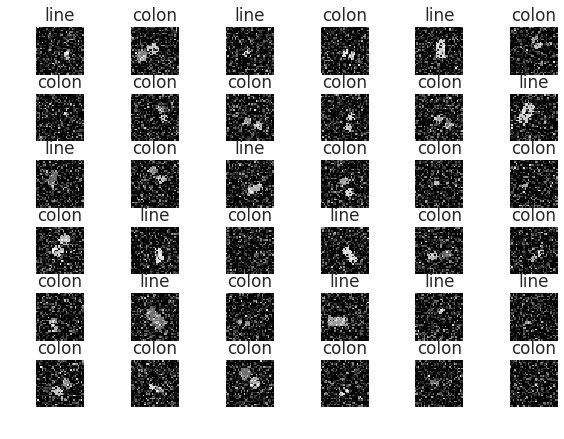

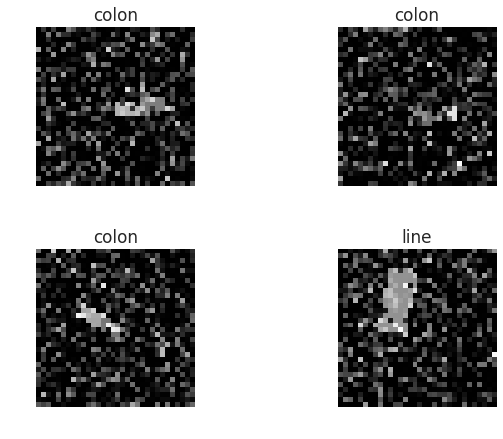

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.87830, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.87830 to 0.88180, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy improved from 0.88180 to 0.88390, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy improved from 0.88390 to 0.88640, saving model to best_model.h5

Epoch 00005: val_categorical_accuracy did not improve from 0.88640

Epoch 00006: val_categorical_accuracy did not improve from 0.88640

Epoch 00007: val_categorical_accuracy improved from 0.88640 to 0.88730, saving model to best_model.h5

Epoch 00008: val_categorical_accuracy improved from 0.88730 to 0.88740, saving model to best_model.h5

Epoch 00009: val_categorical_accuracy did not improve from 0.88740

Epoch 00010: val_categorical_accuracy did not improve from 0.88740

Epoch 00011: val_categorical_accuracy improved from 0.88740 to 0.88840, saving model to 

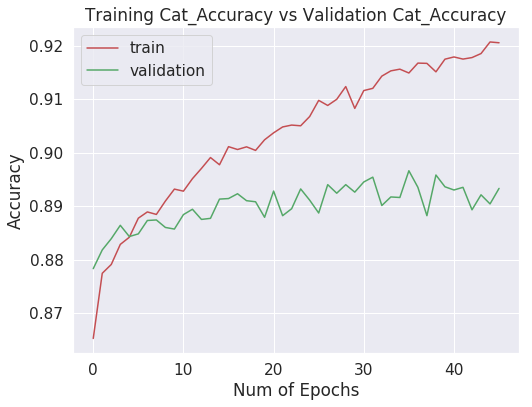

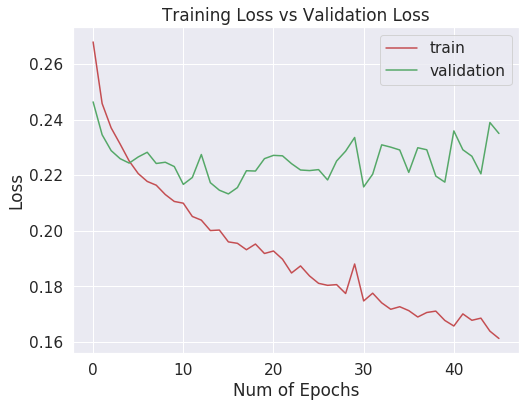

[[4434  572]
 [ 530 4464]]


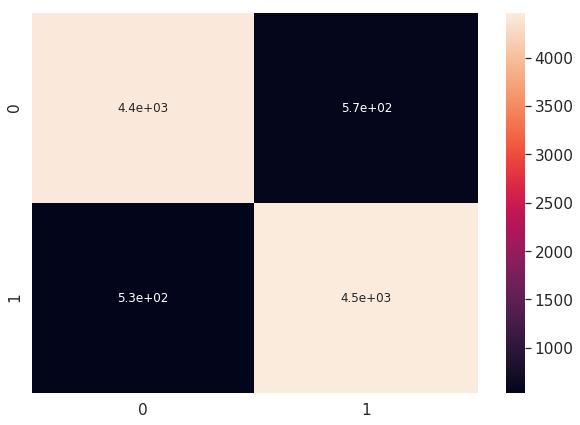

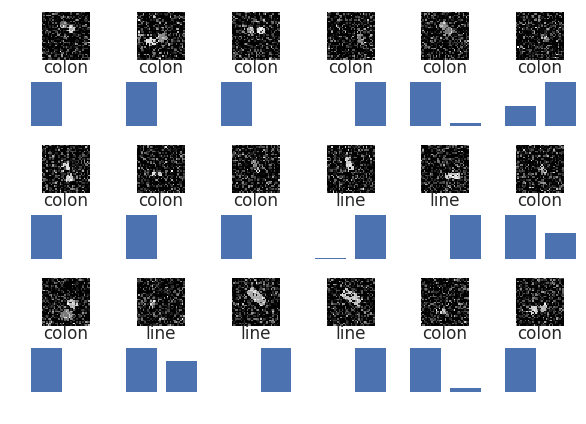

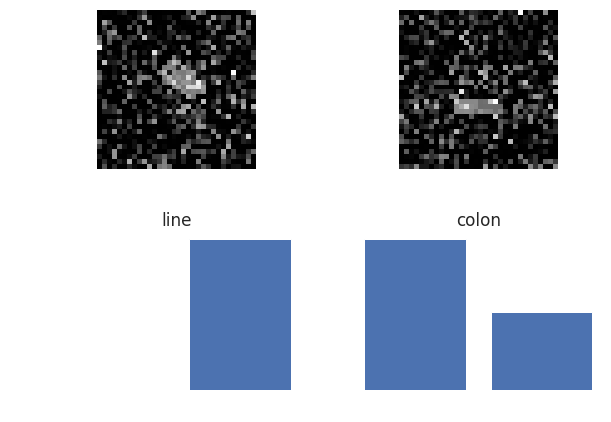

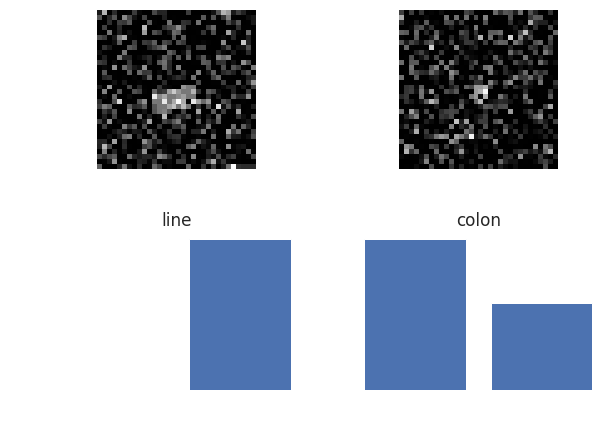

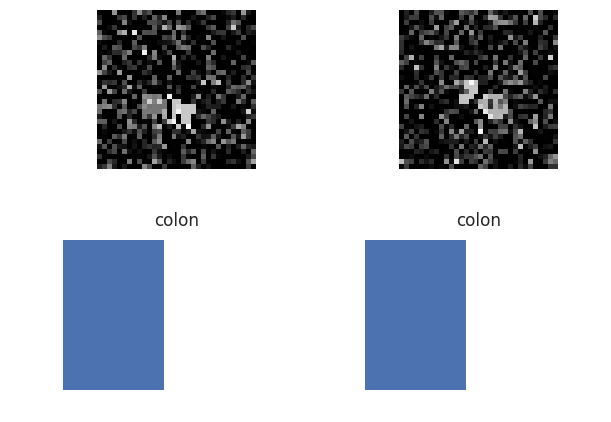

 
 
Extrapolation factor =  1.0
JPEG compression =  80
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


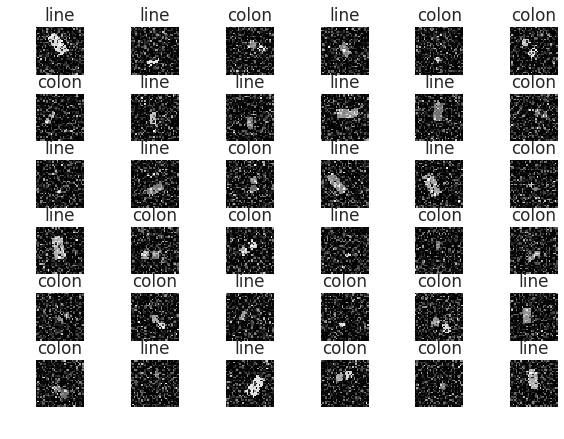

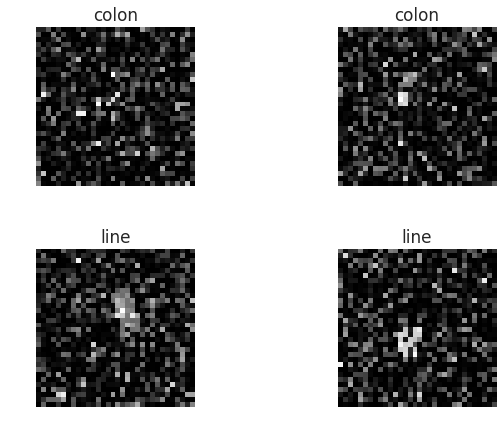

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.89160, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.89160 to 0.89260, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy improved from 0.89260 to 0.89380, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy did not improve from 0.89380

Epoch 00005: val_categorical_accuracy did not improve from 0.89380

Epoch 00006: val_categorical_accuracy improved from 0.89380 to 0.89570, saving model to best_model.h5

Epoch 00007: val_categorical_accuracy did not improve from 0.89570

Epoch 00008: val_categorical_accuracy did not improve from 0.89570

Epoch 00009: val_categorical_accuracy did not improve from 0.89570

Epoch 00010: val_categorical_accuracy did not improve from 0.89570

Epoch 00011: val_categorical_accuracy improved from 0.89570 to 0.89720, saving model to best_model.h5

Epoch 00012: val_categorical_accuracy improved from 0.8

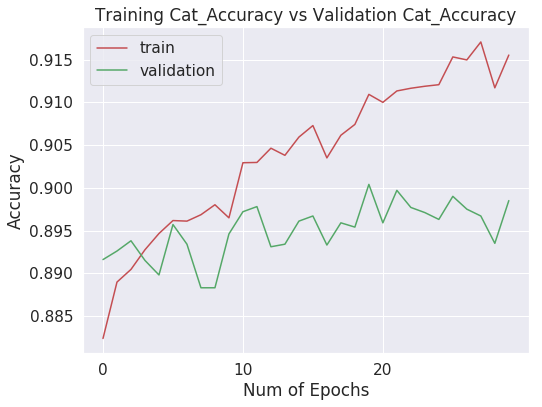

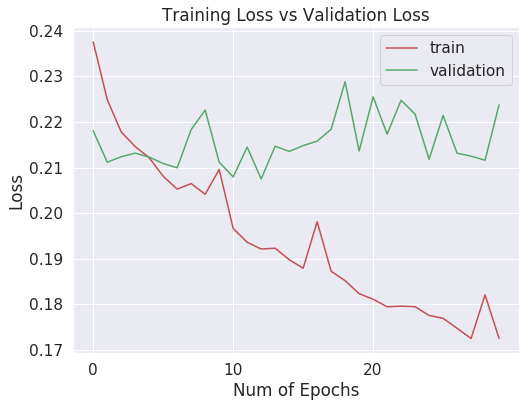

[[4491  604]
 [ 416 4489]]


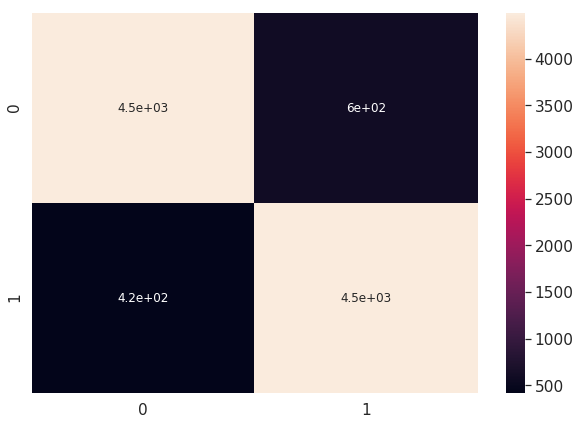

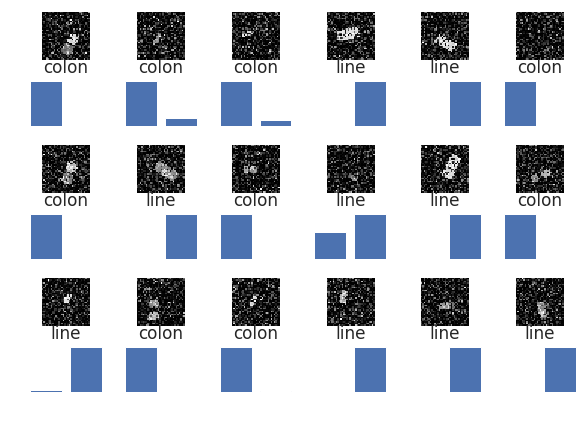

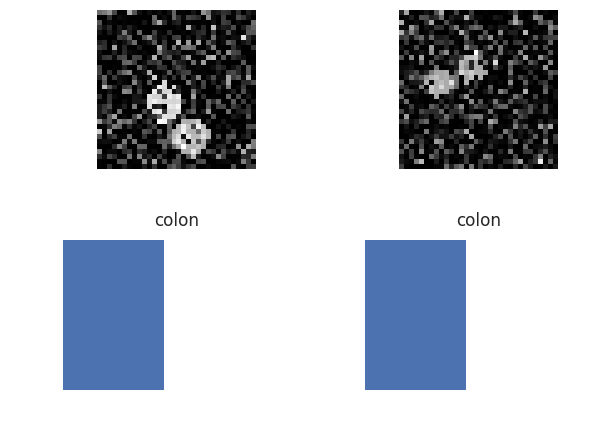

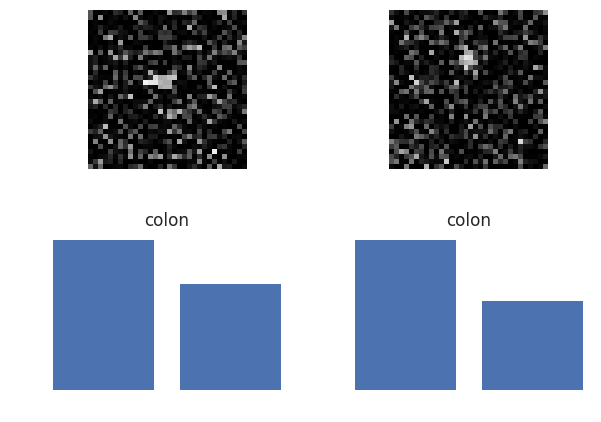

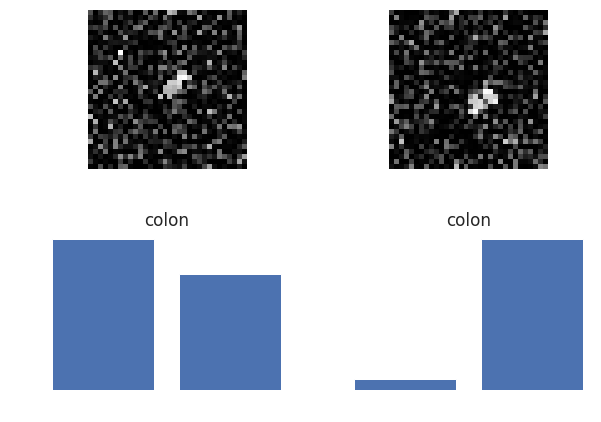

 
 
Extrapolation factor =  1.0
JPEG compression =  32
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


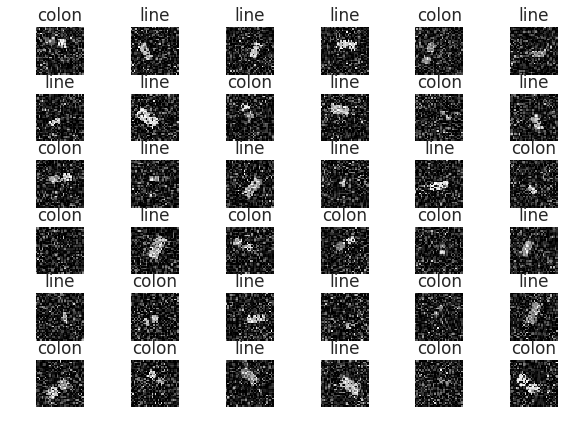

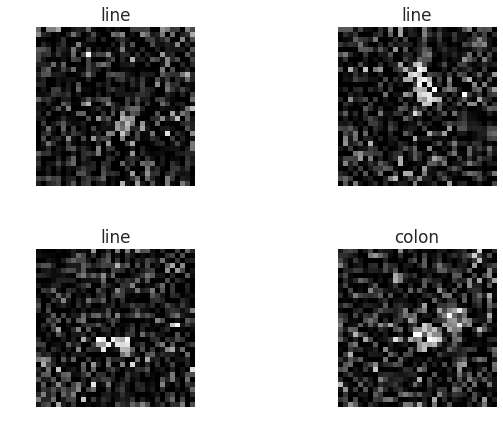

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.88740, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.88740

Epoch 00003: val_categorical_accuracy improved from 0.88740 to 0.89190, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy did not improve from 0.89190

Epoch 00005: val_categorical_accuracy did not improve from 0.89190

Epoch 00006: val_categorical_accuracy improved from 0.89190 to 0.89200, saving model to best_model.h5

Epoch 00007: val_categorical_accuracy did not improve from 0.89200

Epoch 00008: val_categorical_accuracy did not improve from 0.89200

Epoch 00009: val_categorical_accuracy did not improve from 0.89200

Epoch 00010: val_categorical_accuracy did not improve from 0.89200

Epoch 00011: val_categorical_accuracy did not improve from 0.89200

Epoch 00012: val_categorical_accuracy did not improve from 0.89200

Epoch 00013: val_categorical_accuracy improved from 0.892

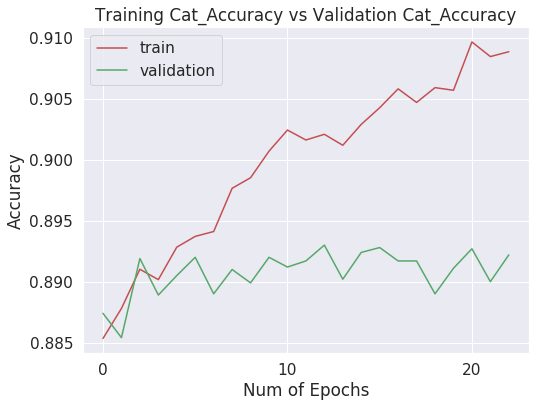

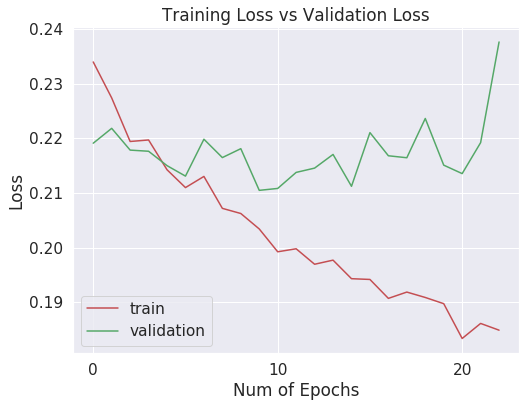

[[4338  633]
 [ 420 4609]]


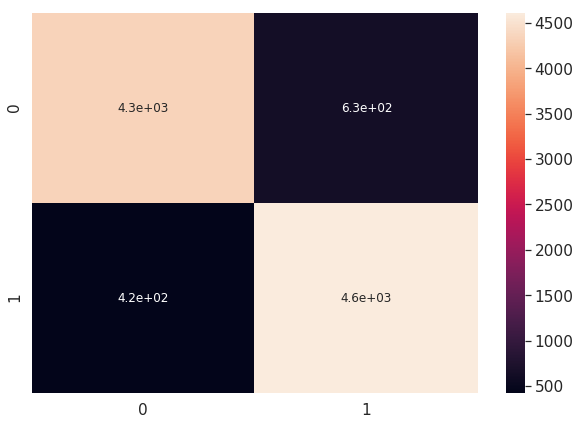

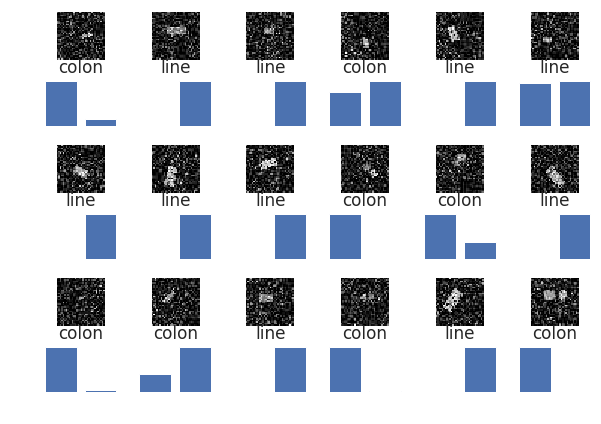

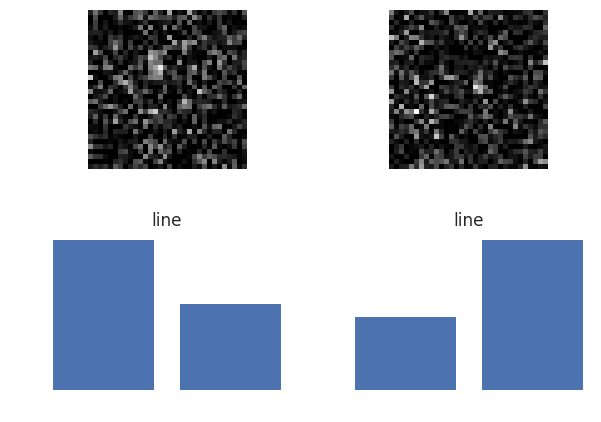

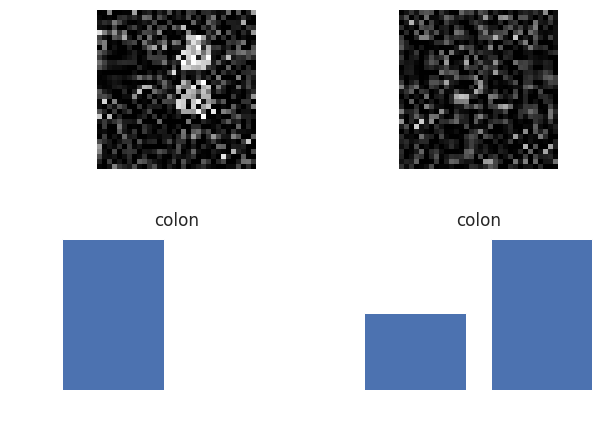

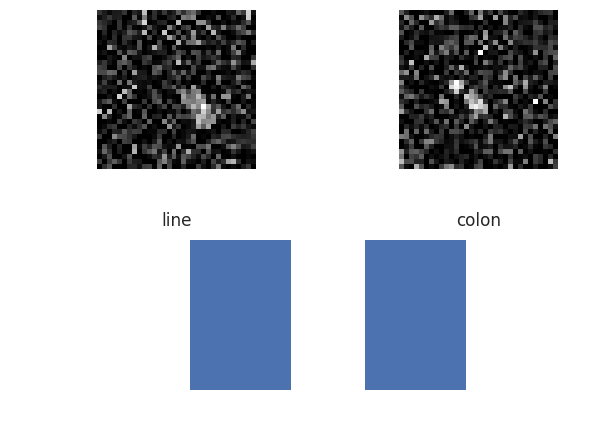

 
 
Extrapolation factor =  1.0
JPEG compression =  15
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


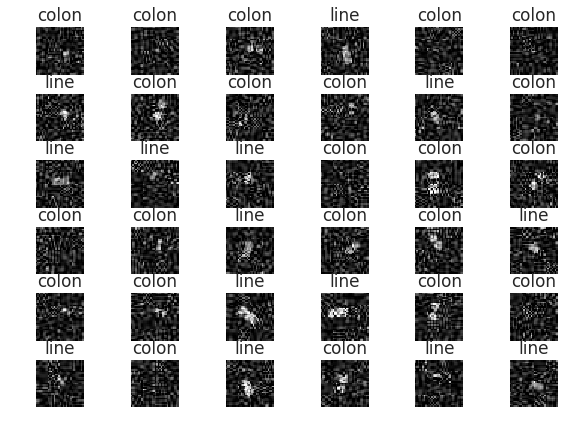

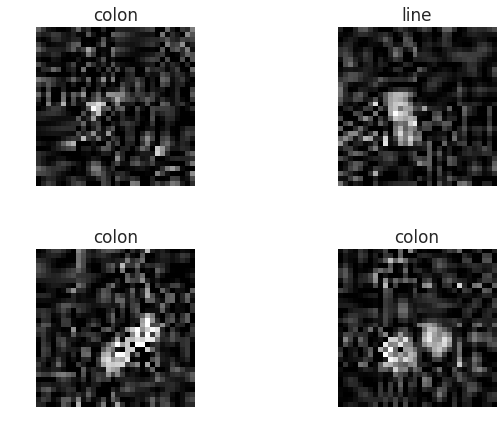

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.88650, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.88650

Epoch 00003: val_categorical_accuracy improved from 0.88650 to 0.88750, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy did not improve from 0.88750

Epoch 00005: val_categorical_accuracy did not improve from 0.88750

Epoch 00006: val_categorical_accuracy did not improve from 0.88750

Epoch 00007: val_categorical_accuracy improved from 0.88750 to 0.88980, saving model to best_model.h5

Epoch 00008: val_categorical_accuracy did not improve from 0.88980

Epoch 00009: val_categorical_accuracy did not improve from 0.88980

Epoch 00010: val_categorical_accuracy did not improve from 0.88980

Epoch 00011: val_categorical_accuracy did not improve from 0.88980

Epoch 00012: val_categorical_accuracy did not improve from 0.88980

Epoch 00013: val_categorical_accuracy did not improve fro

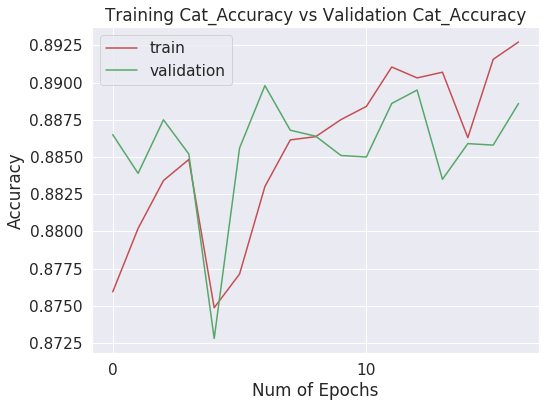

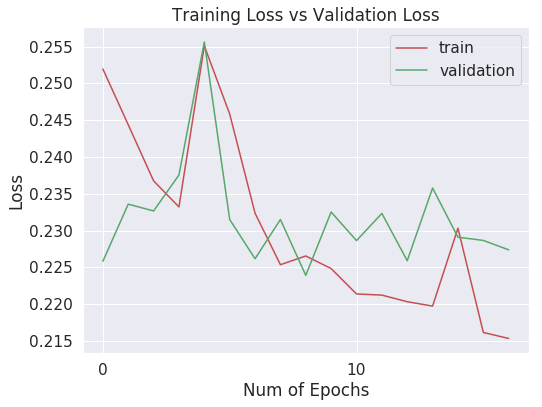

[[4176  772]
 [ 362 4690]]


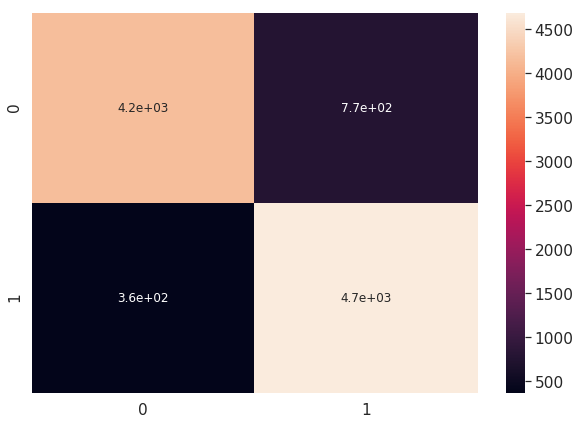

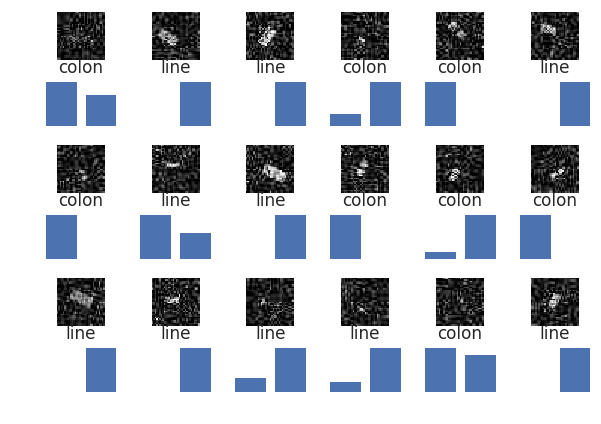

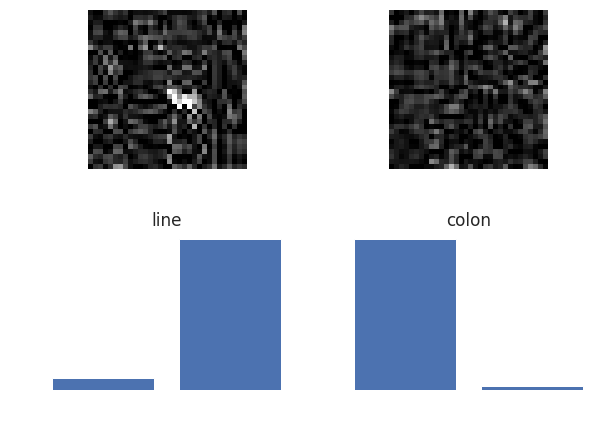

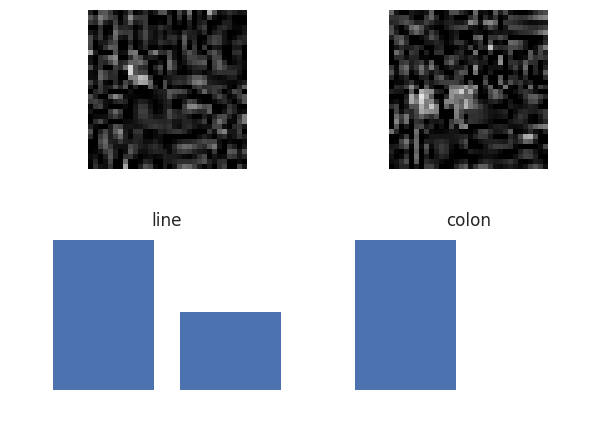

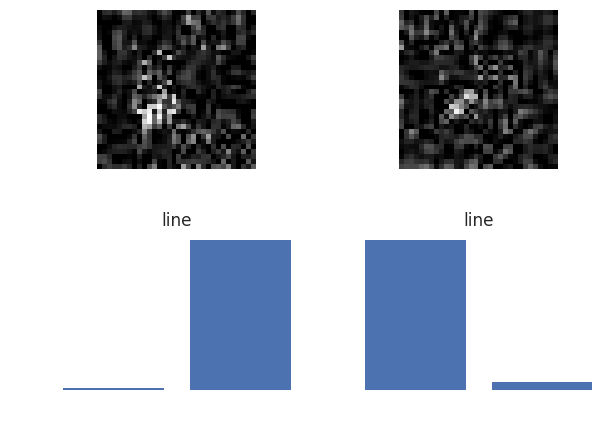

 
 
Extrapolation factor =  1.0
JPEG compression =  7
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


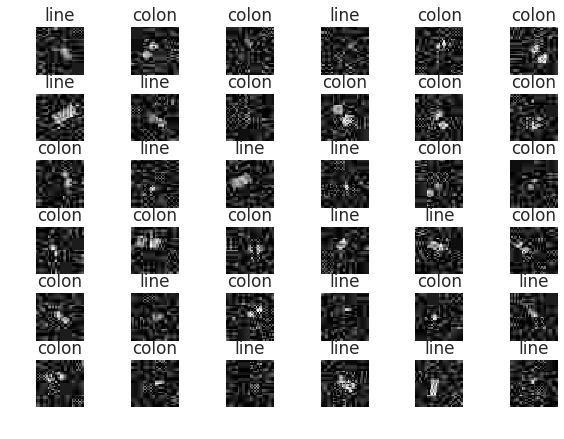

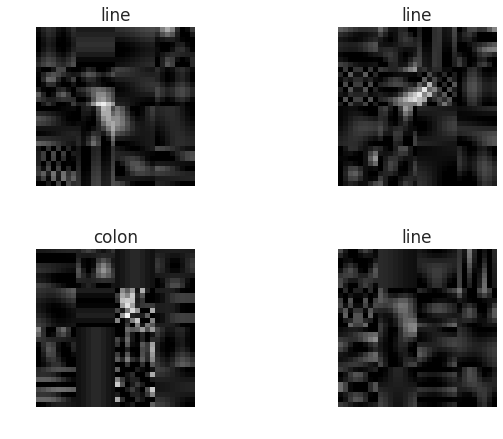

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.86880, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.86880 to 0.86950, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy did not improve from 0.86950

Epoch 00004: val_categorical_accuracy did not improve from 0.86950

Epoch 00005: val_categorical_accuracy improved from 0.86950 to 0.87260, saving model to best_model.h5

Epoch 00006: val_categorical_accuracy did not improve from 0.87260

Epoch 00007: val_categorical_accuracy did not improve from 0.87260

Epoch 00008: val_categorical_accuracy did not improve from 0.87260

Epoch 00009: val_categorical_accuracy did not improve from 0.87260

Epoch 00010: val_categorical_accuracy did not improve from 0.87260

Epoch 00011: val_categorical_accuracy did not improve from 0.87260

Epoch 00012: val_categorical_accuracy did not improve from 0.87260

Epoch 00013: val_categorical_accuracy improved from 0.872

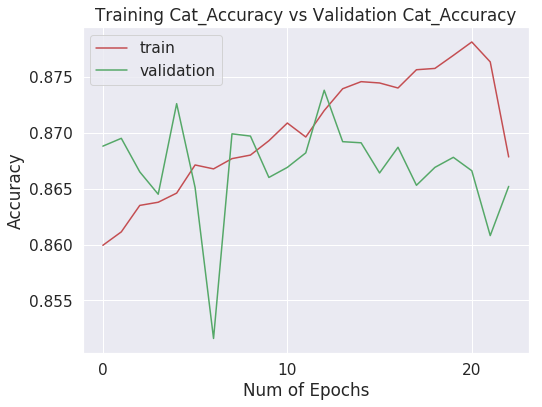

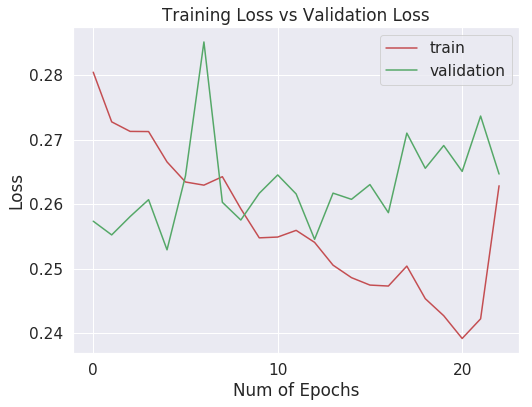

[[4238  780]
 [ 531 4451]]


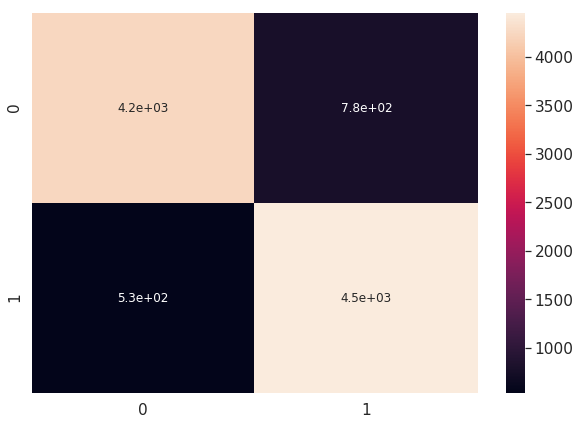

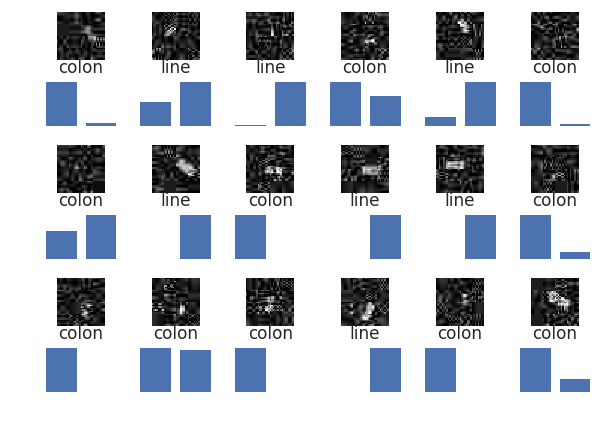

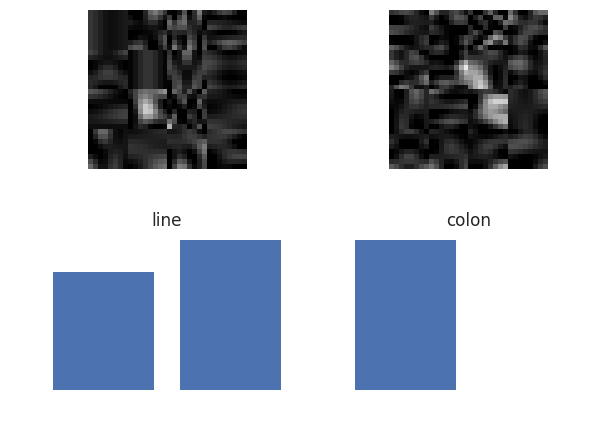

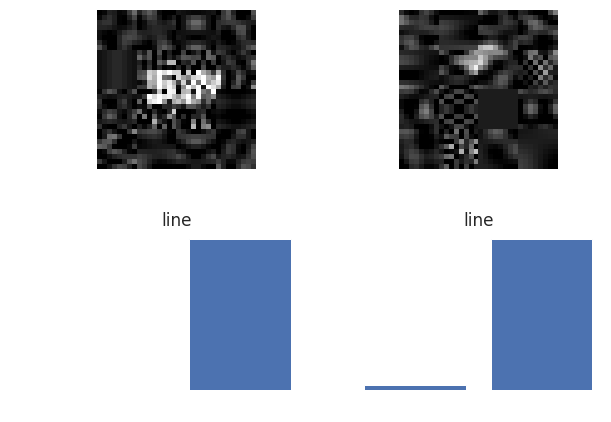

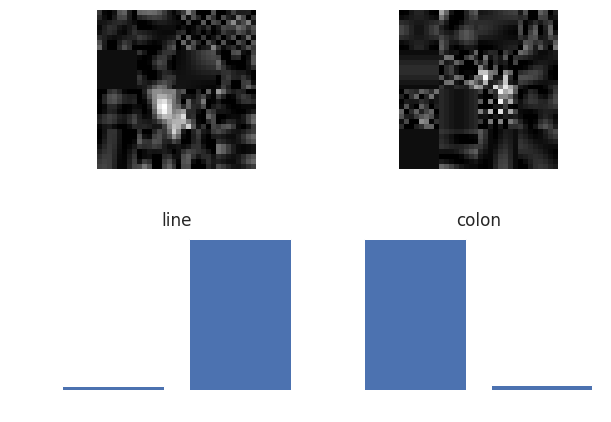

 
 
Extrapolation factor =  1.0
JPEG compression =  3
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


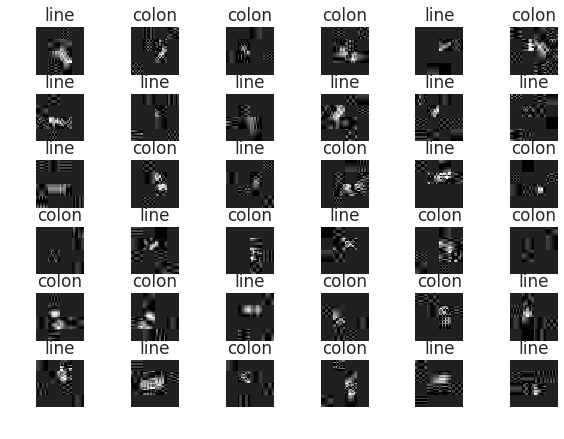

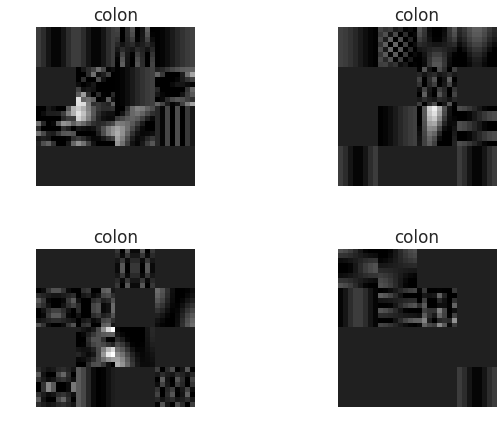

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.81410, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.81410 to 0.81670, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy did not improve from 0.81670

Epoch 00004: val_categorical_accuracy improved from 0.81670 to 0.82080, saving model to best_model.h5

Epoch 00005: val_categorical_accuracy improved from 0.82080 to 0.82160, saving model to best_model.h5

Epoch 00006: val_categorical_accuracy did not improve from 0.82160

Epoch 00007: val_categorical_accuracy did not improve from 0.82160

Epoch 00008: val_categorical_accuracy did not improve from 0.82160

Epoch 00009: val_categorical_accuracy did not improve from 0.82160

Epoch 00010: val_categorical_accuracy did not improve from 0.82160

Epoch 00011: val_categorical_accuracy improved from 0.82160 to 0.82330, saving model to best_model.h5

Epoch 00012: val_categorical_accuracy did not improve f

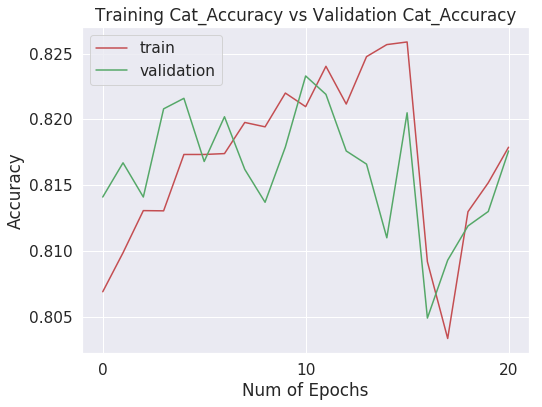

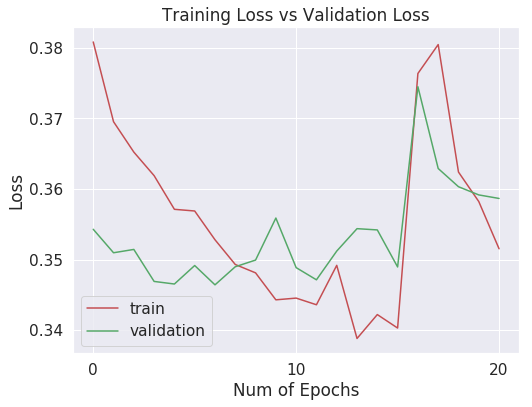

[[4065  911]
 [ 856 4168]]


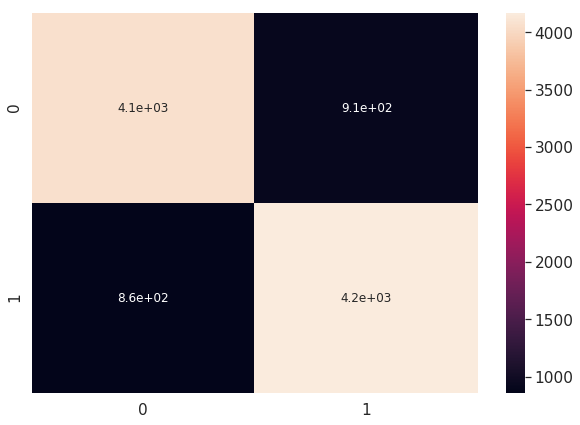

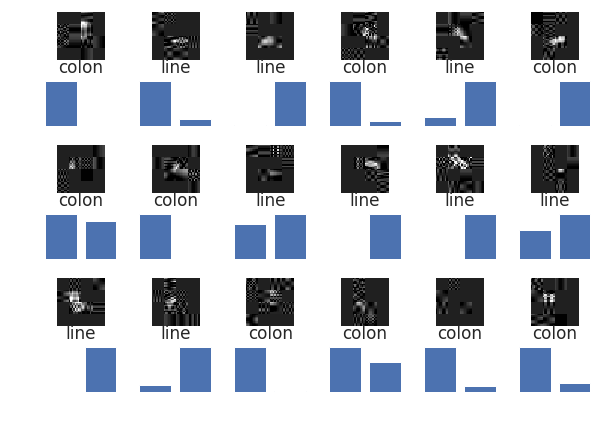

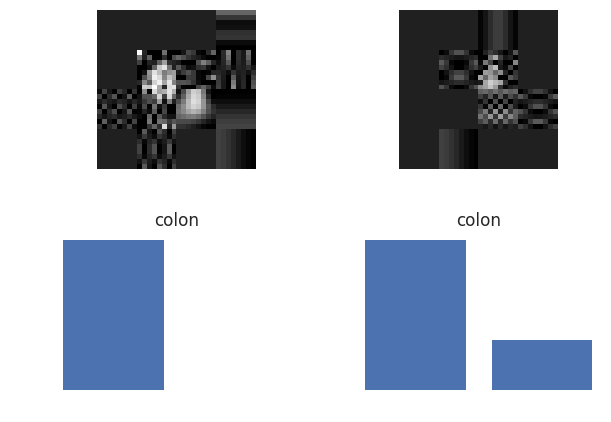

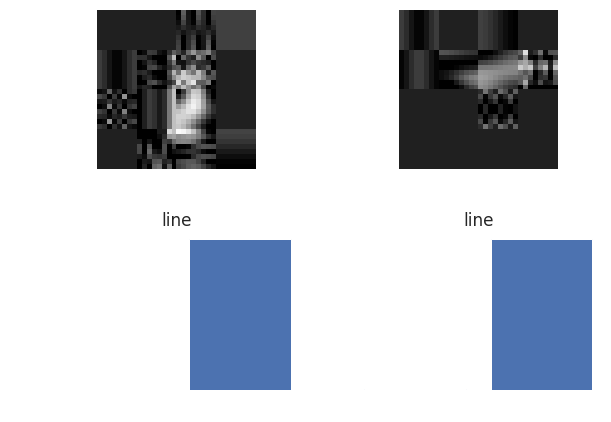

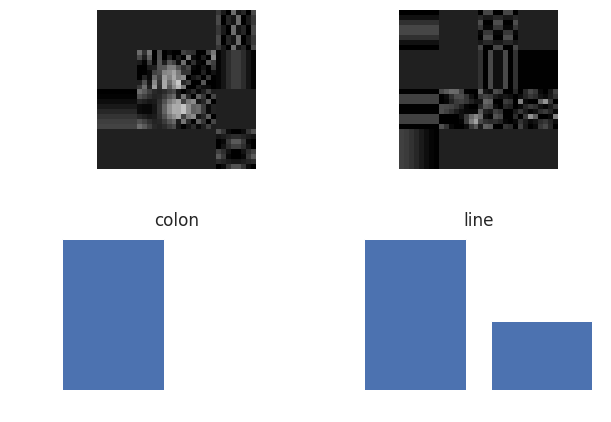

 
 
Extrapolation factor =  2.0
JPEG compression =  97
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


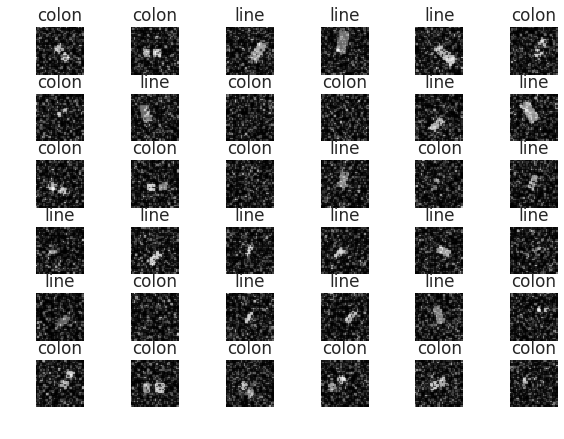

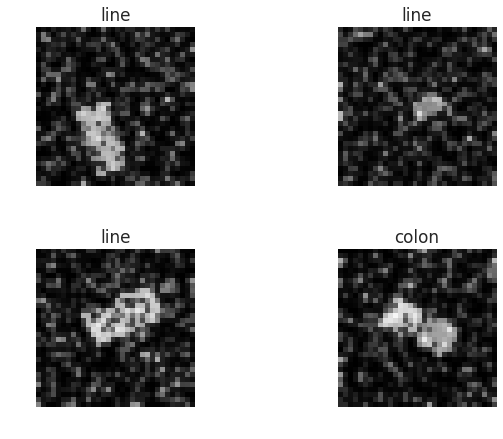

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.88690, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.88690

Epoch 00003: val_categorical_accuracy improved from 0.88690 to 0.89130, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy did not improve from 0.89130

Epoch 00005: val_categorical_accuracy improved from 0.89130 to 0.89450, saving model to best_model.h5

Epoch 00006: val_categorical_accuracy did not improve from 0.89450

Epoch 00007: val_categorical_accuracy did not improve from 0.89450

Epoch 00008: val_categorical_accuracy improved from 0.89450 to 0.89610, saving model to best_model.h5

Epoch 00009: val_categorical_accuracy did not improve from 0.89610

Epoch 00010: val_categorical_accuracy did not improve from 0.89610

Epoch 00011: val_categorical_accuracy did not improve from 0.89610

Epoch 00012: val_categorical_accuracy improved from 0.89610 to 0.89680, saving model to be

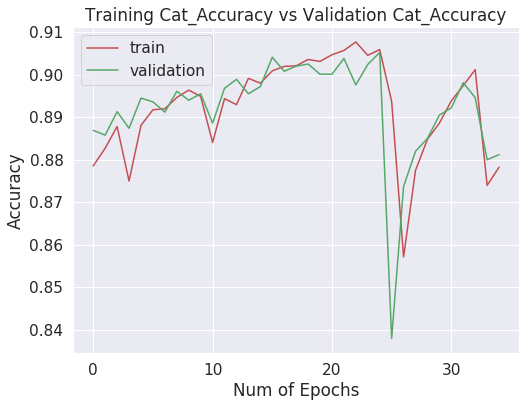

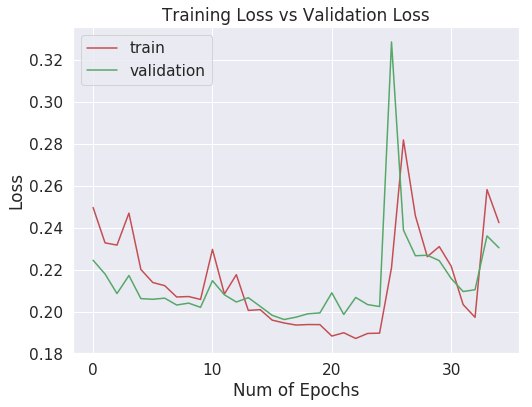

[[4297  703]
 [ 282 4718]]


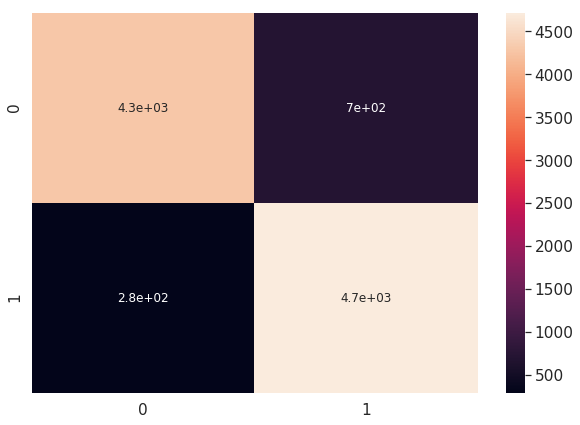

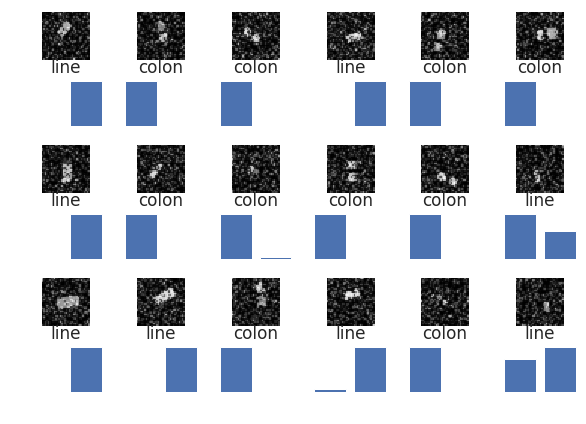

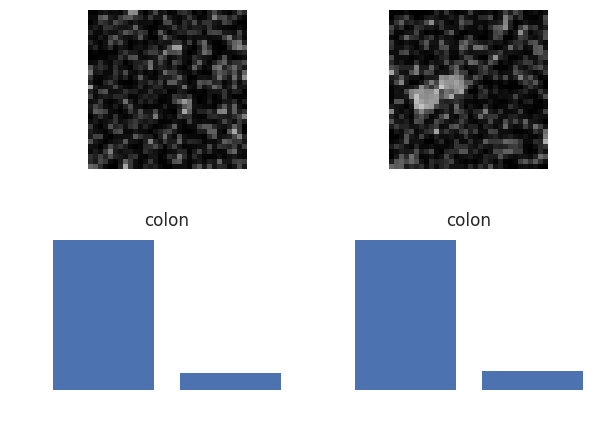

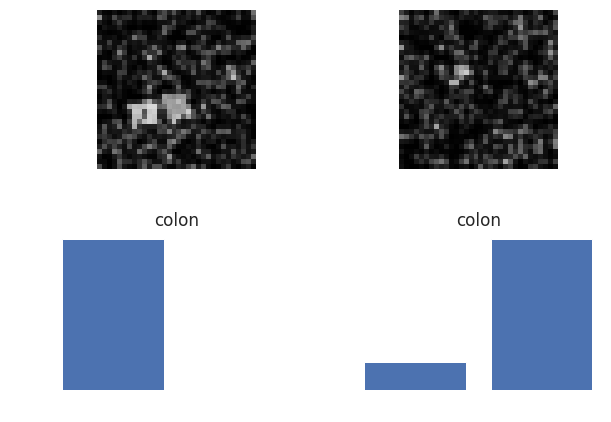

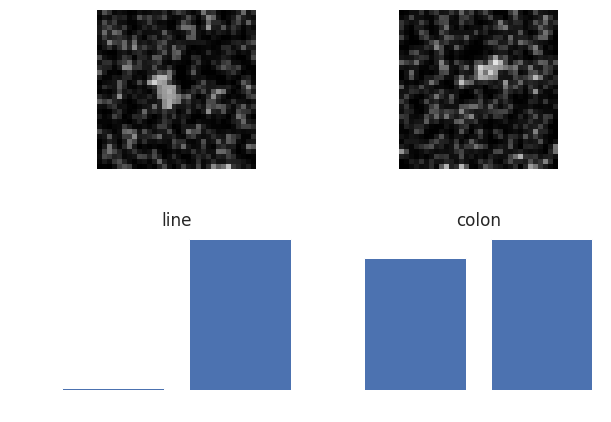

 
 
Extrapolation factor =  2.0
JPEG compression =  80
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


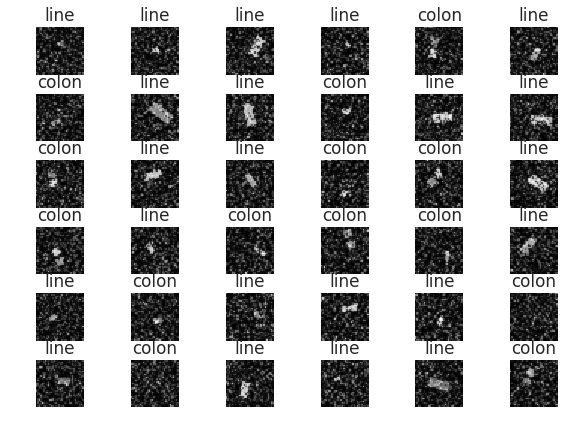

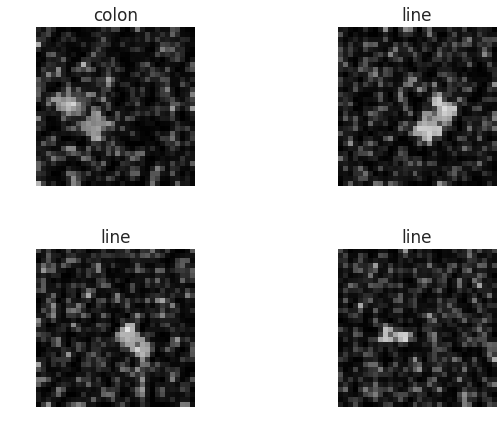

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.90090, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.90090 to 0.90110, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy did not improve from 0.90110

Epoch 00004: val_categorical_accuracy improved from 0.90110 to 0.90200, saving model to best_model.h5

Epoch 00005: val_categorical_accuracy did not improve from 0.90200

Epoch 00006: val_categorical_accuracy did not improve from 0.90200

Epoch 00007: val_categorical_accuracy did not improve from 0.90200

Epoch 00008: val_categorical_accuracy improved from 0.90200 to 0.90470, saving model to best_model.h5

Epoch 00009: val_categorical_accuracy did not improve from 0.90470

Epoch 00010: val_categorical_accuracy did not improve from 0.90470

Epoch 00011: val_categorical_accuracy did not improve from 0.90470

Epoch 00012: val_categorical_accuracy did not improve from 0.90470

Epoch 00013: val_categ

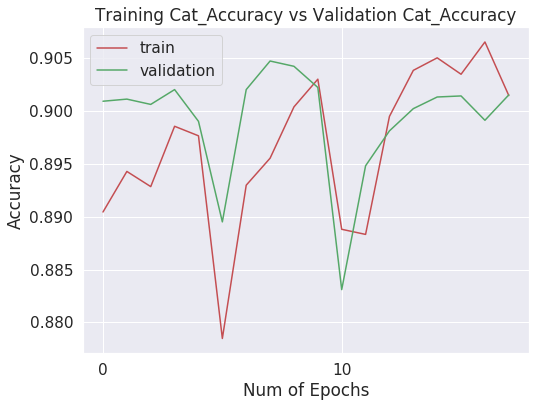

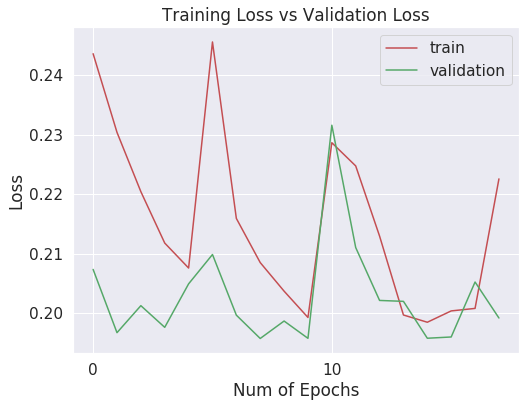

[[4397  556]
 [ 397 4650]]


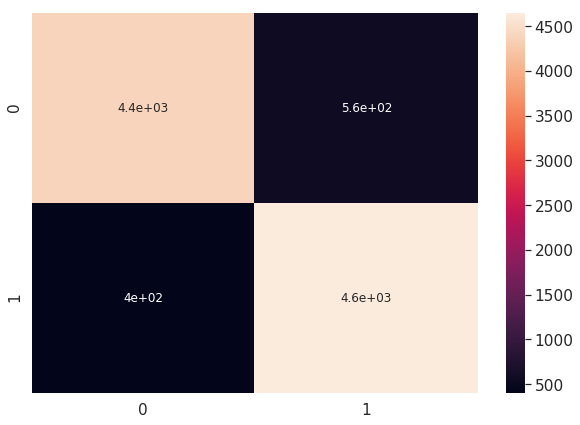

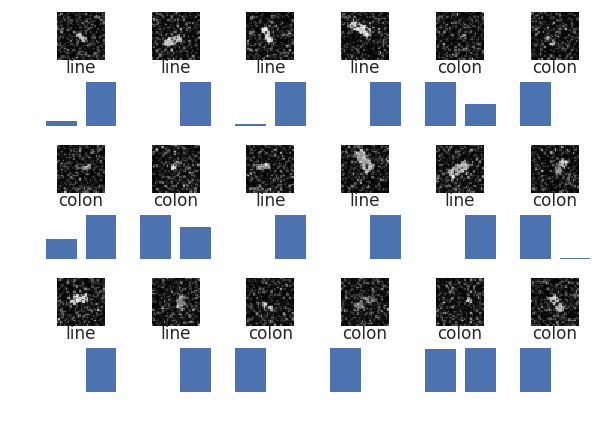

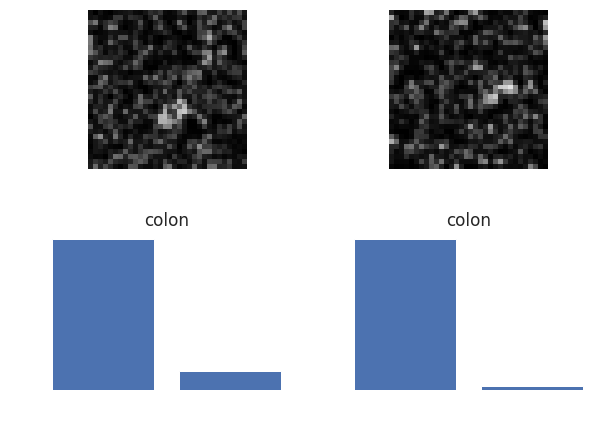

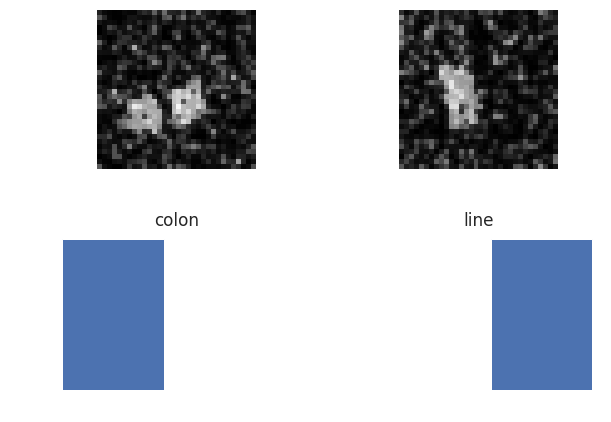

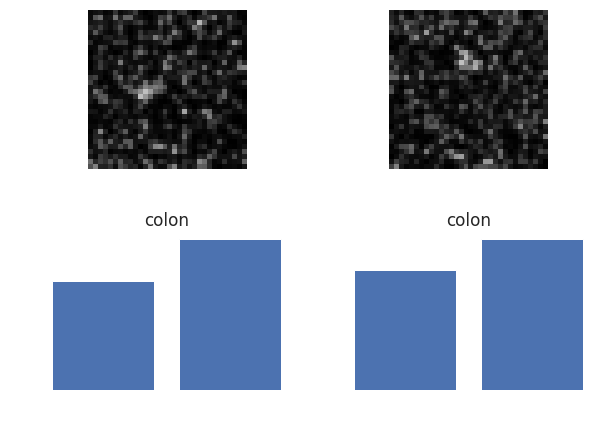

 
 
Extrapolation factor =  2.0
JPEG compression =  32
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


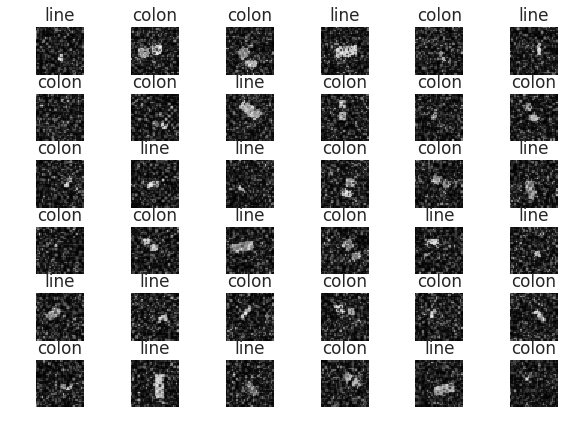

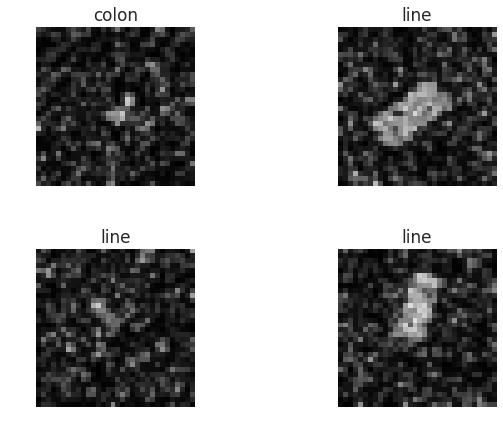

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.89510, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.89510

Epoch 00003: val_categorical_accuracy did not improve from 0.89510

Epoch 00004: val_categorical_accuracy did not improve from 0.89510

Epoch 00005: val_categorical_accuracy improved from 0.89510 to 0.89550, saving model to best_model.h5

Epoch 00006: val_categorical_accuracy did not improve from 0.89550

Epoch 00007: val_categorical_accuracy did not improve from 0.89550

Epoch 00008: val_categorical_accuracy did not improve from 0.89550

Epoch 00009: val_categorical_accuracy did not improve from 0.89550

Epoch 00010: val_categorical_accuracy did not improve from 0.89550

Epoch 00011: val_categorical_accuracy did not improve from 0.89550

Epoch 00012: val_categorical_accuracy did not improve from 0.89550

Epoch 00013: val_categorical_accuracy did not improve from 0.89550

Epoch 00014: val_categor

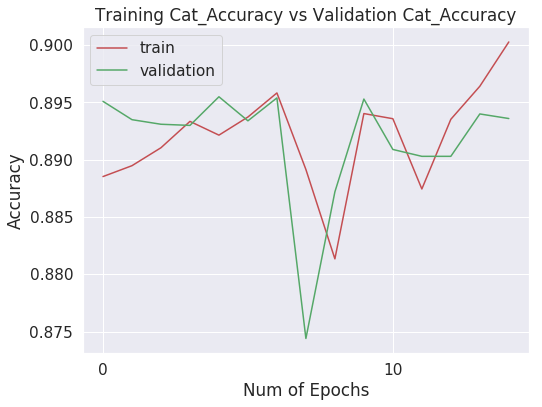

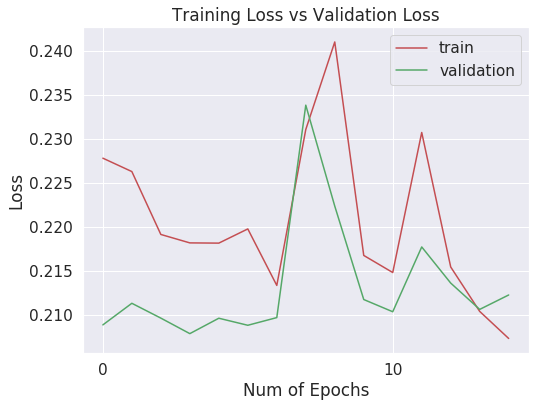

[[4278  665]
 [ 370 4687]]


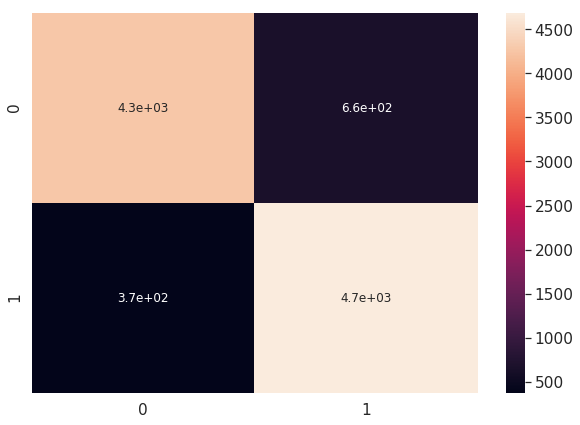

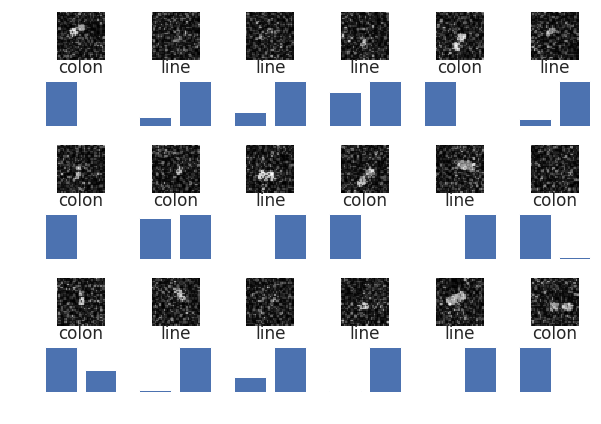

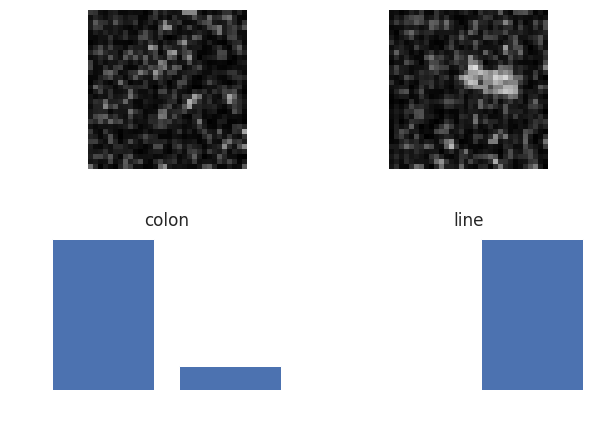

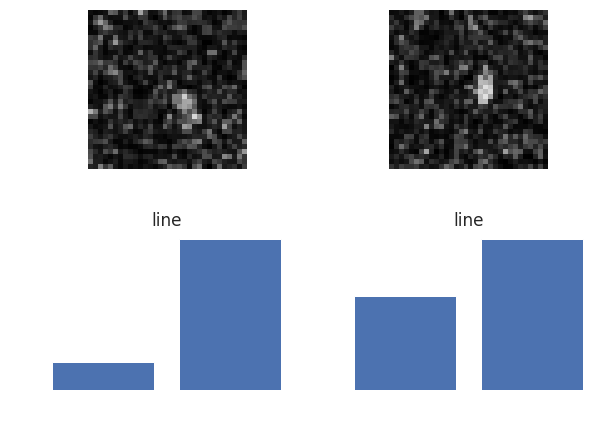

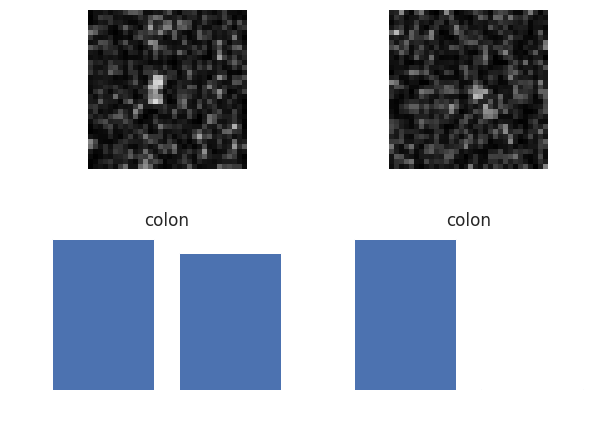

 
 
Extrapolation factor =  2.0
JPEG compression =  15
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


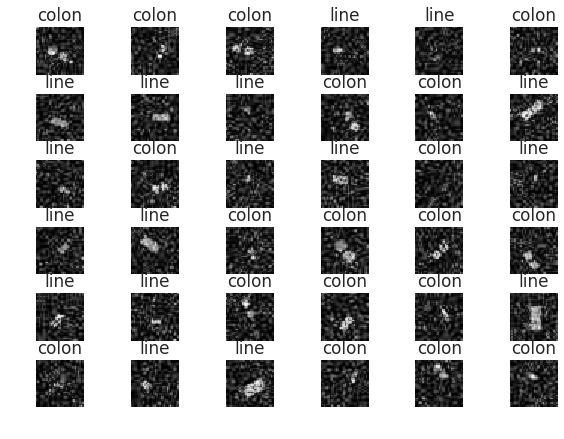

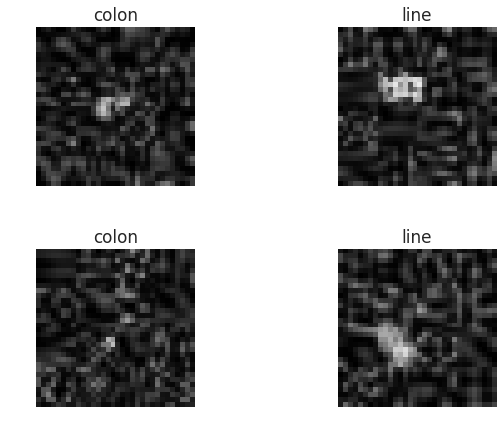

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.88330, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.88330

Epoch 00003: val_categorical_accuracy improved from 0.88330 to 0.88460, saving model to best_model.h5

Epoch 00004: val_categorical_accuracy did not improve from 0.88460

Epoch 00005: val_categorical_accuracy did not improve from 0.88460

Epoch 00006: val_categorical_accuracy did not improve from 0.88460

Epoch 00007: val_categorical_accuracy did not improve from 0.88460

Epoch 00008: val_categorical_accuracy did not improve from 0.88460

Epoch 00009: val_categorical_accuracy improved from 0.88460 to 0.88660, saving model to best_model.h5

Epoch 00010: val_categorical_accuracy did not improve from 0.88660

Epoch 00011: val_categorical_accuracy did not improve from 0.88660

Epoch 00012: val_categorical_accuracy did not improve from 0.88660

Epoch 00013: val_categorical_accuracy did not improve fro

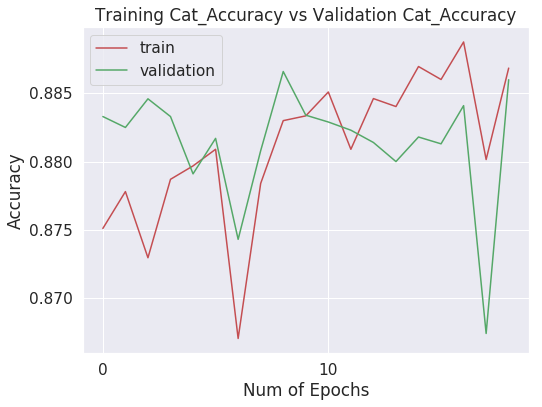

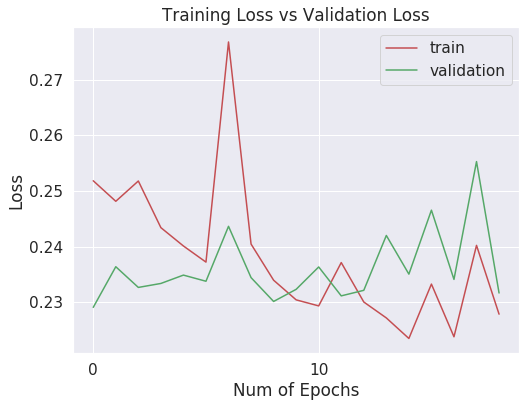

[[4329  735]
 [ 382 4554]]


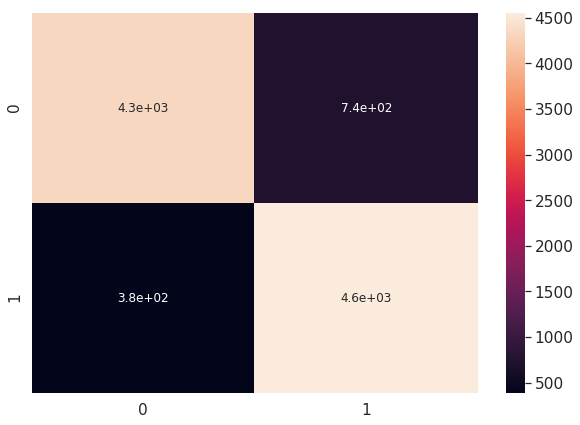

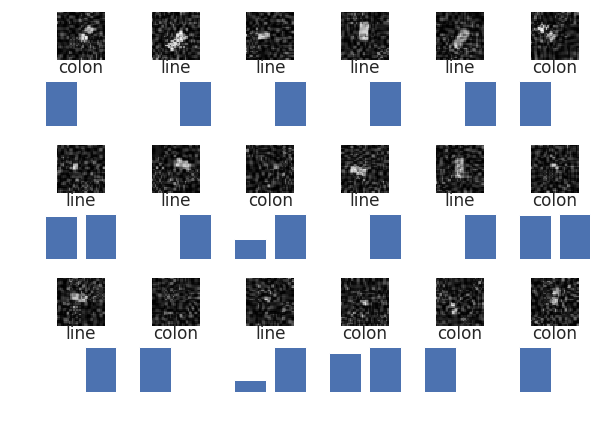

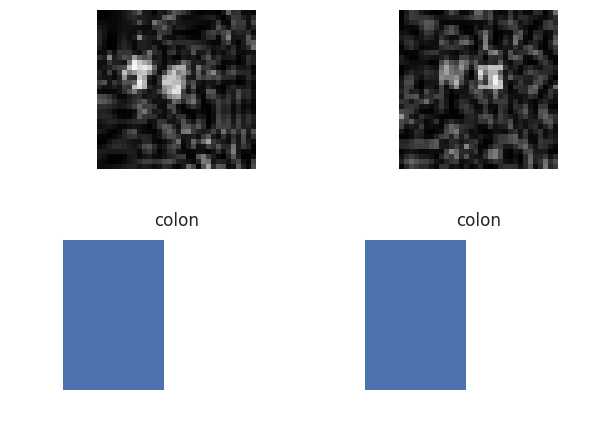

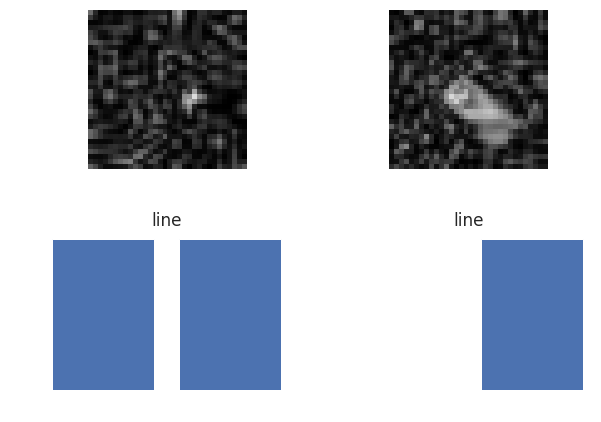

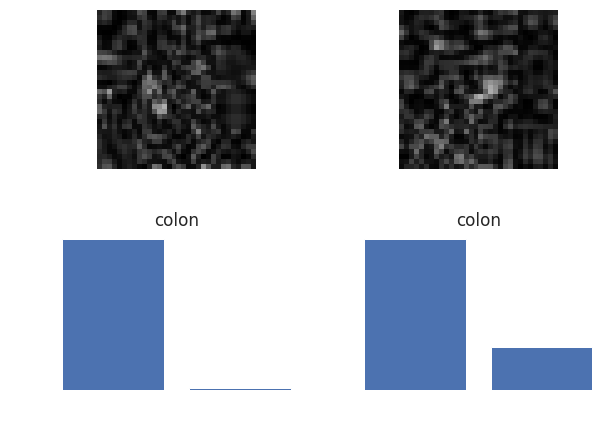

 
 
Extrapolation factor =  2.0
JPEG compression =  7
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


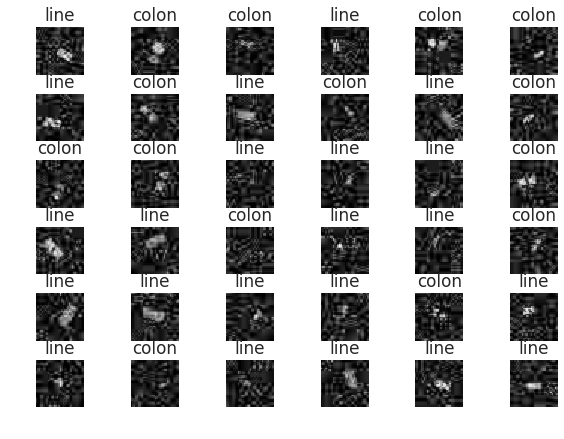

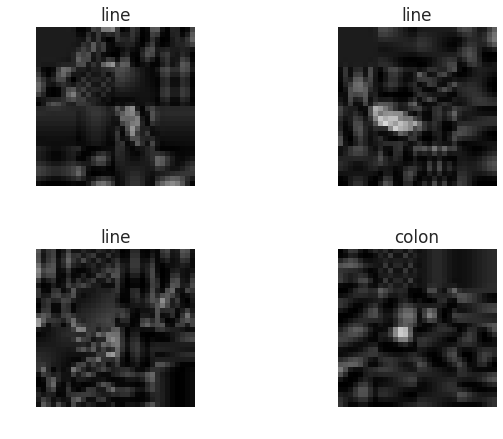

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.85580, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy did not improve from 0.85580

Epoch 00003: val_categorical_accuracy did not improve from 0.85580

Epoch 00004: val_categorical_accuracy did not improve from 0.85580

Epoch 00005: val_categorical_accuracy did not improve from 0.85580

Epoch 00006: val_categorical_accuracy did not improve from 0.85580

Epoch 00007: val_categorical_accuracy improved from 0.85580 to 0.85900, saving model to best_model.h5

Epoch 00008: val_categorical_accuracy did not improve from 0.85900

Epoch 00009: val_categorical_accuracy did not improve from 0.85900

Epoch 00010: val_categorical_accuracy did not improve from 0.85900

Epoch 00011: val_categorical_accuracy did not improve from 0.85900

Epoch 00012: val_categorical_accuracy did not improve from 0.85900

Epoch 00013: val_categorical_accuracy did not improve from 0.85900

Epoch 00014: val_categor

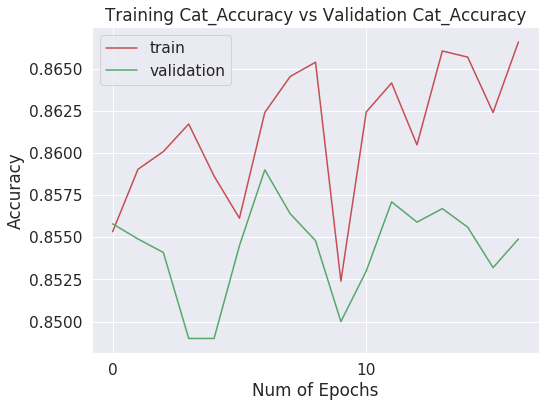

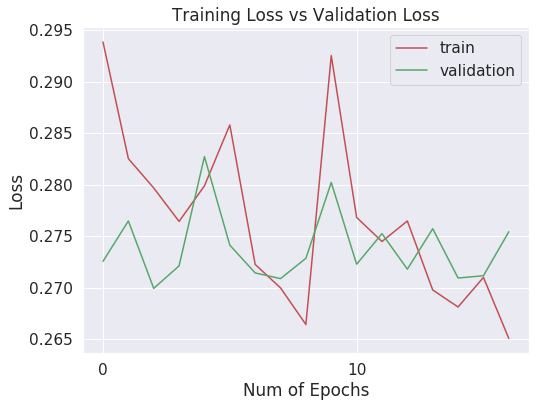

[[4323  724]
 [ 532 4421]]


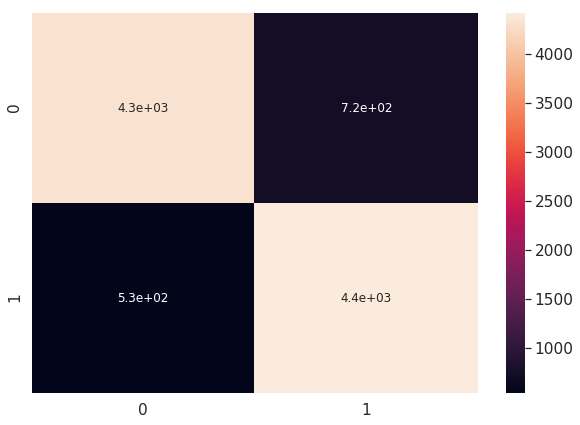

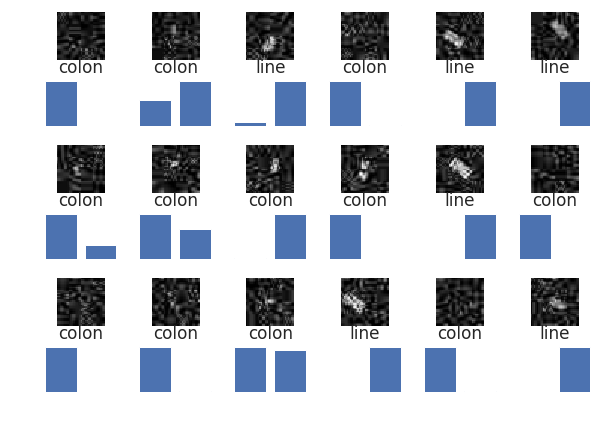

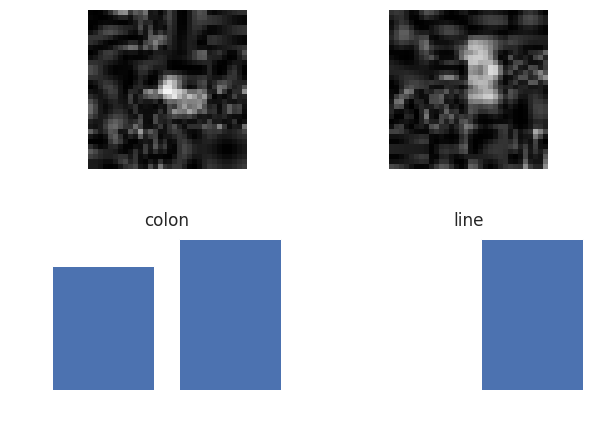

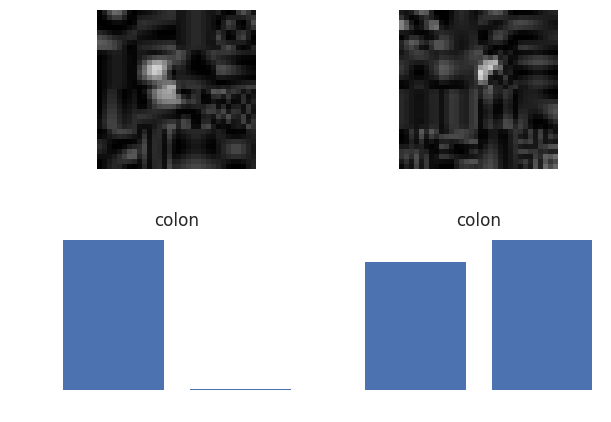

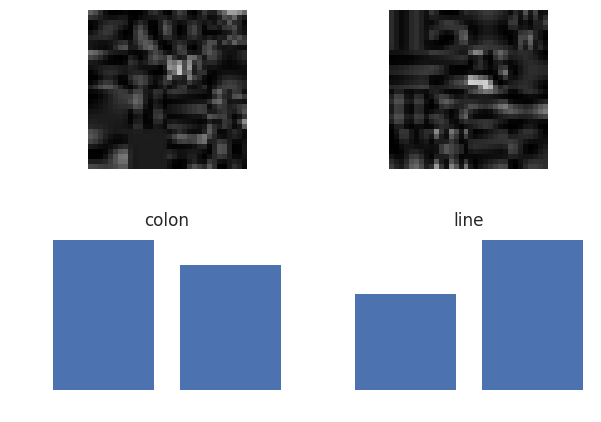

 
 
Extrapolation factor =  2.0
JPEG compression =  3
 
 
Figures created
Noise added
Distorting image  9999
Distorting image  19999
Distorting image  29999
Distorting image  39999
Distorting image  49999
Distorting image  59999
Distorting image  9999
Distorting image  9999
Images distorted


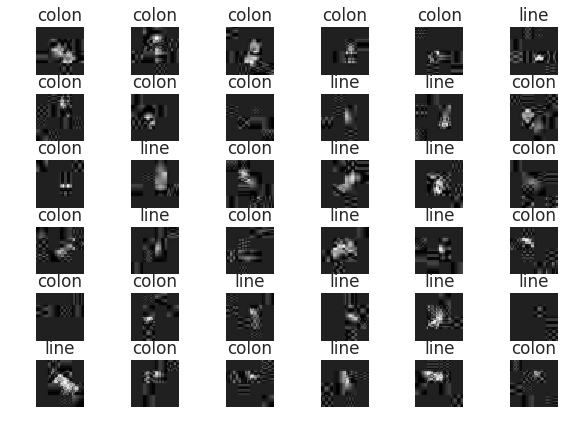

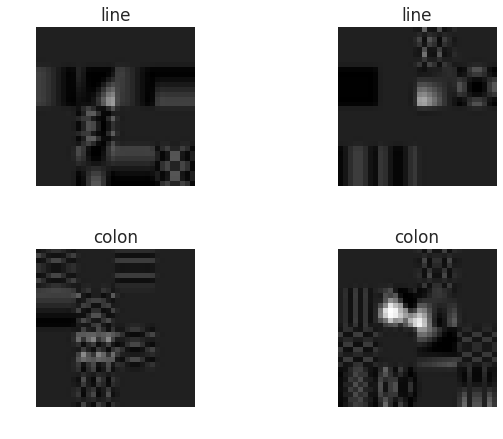

yy_train  (60000, 1, 2)

Epoch 00001: val_categorical_accuracy improved from -inf to 0.82140, saving model to best_model.h5

Epoch 00002: val_categorical_accuracy improved from 0.82140 to 0.82200, saving model to best_model.h5

Epoch 00003: val_categorical_accuracy did not improve from 0.82200

Epoch 00004: val_categorical_accuracy did not improve from 0.82200

Epoch 00005: val_categorical_accuracy did not improve from 0.82200

Epoch 00006: val_categorical_accuracy did not improve from 0.82200

Epoch 00007: val_categorical_accuracy did not improve from 0.82200

Epoch 00008: val_categorical_accuracy did not improve from 0.82200

Epoch 00009: val_categorical_accuracy did not improve from 0.82200

Epoch 00010: val_categorical_accuracy did not improve from 0.82200

Epoch 00011: val_categorical_accuracy did not improve from 0.82200

Epoch 00012: val_categorical_accuracy did not improve from 0.82200
Epoch 00012: early stopping
Accuracy Train: 81.87% , Test: 82.20% Val: 81.75% 


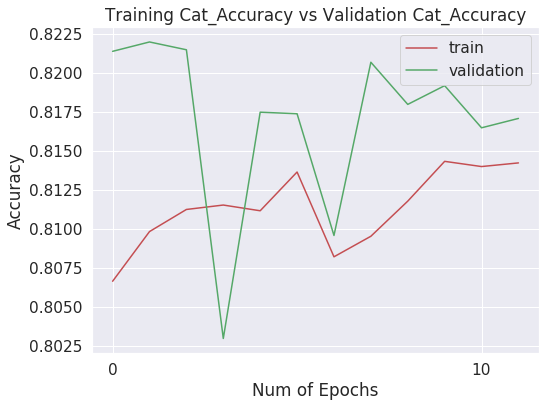

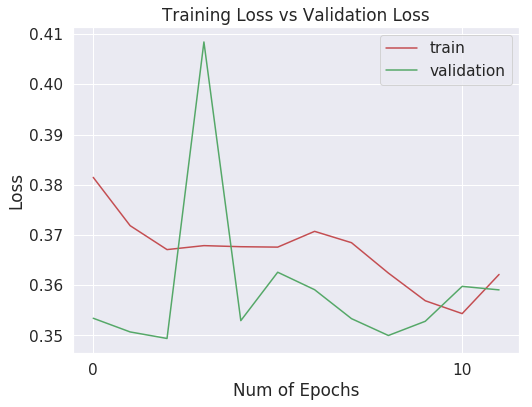

[[3900 1077]
 [ 748 4275]]


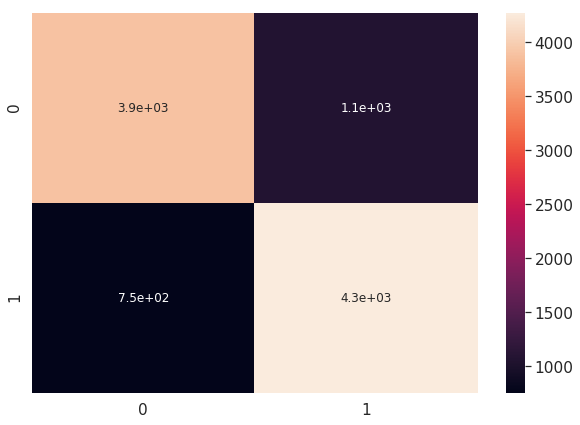

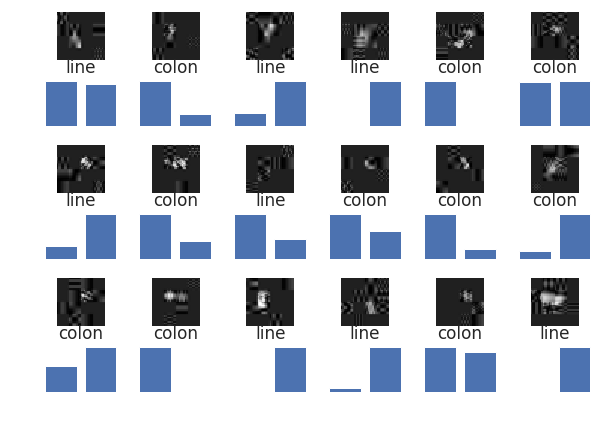

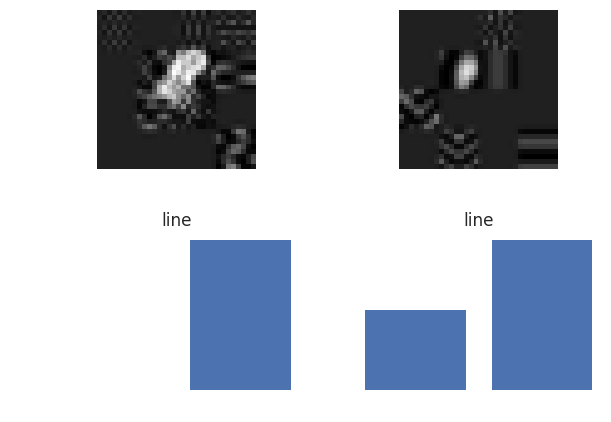

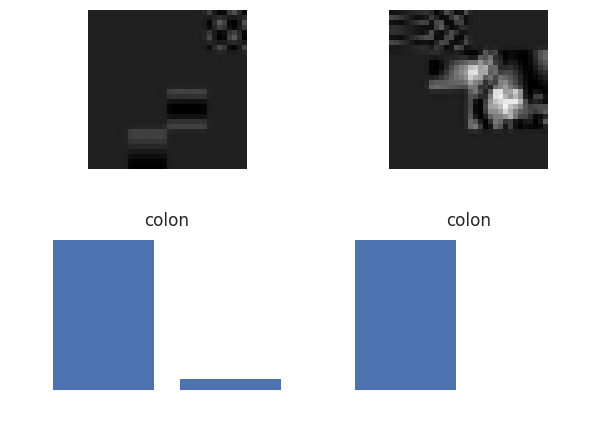

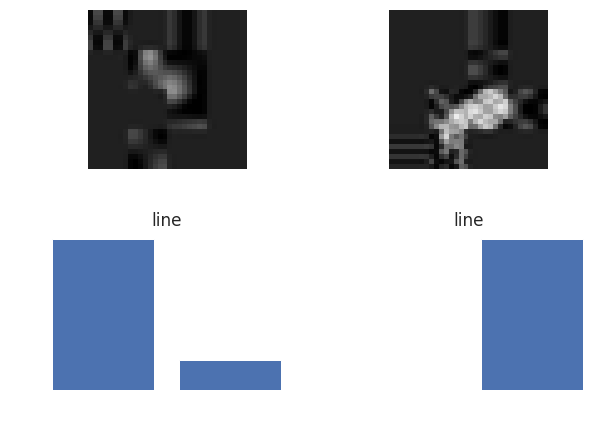

In [19]:
#acc_scores = []
#loss_scores = []

outcome = []

# Loop over extrapolations
for extrapolation_factor in extrapolation_list:

 # Loop over jpeg qualities
 if jpeg_format == 'jpeg':
   compression_list = jpeg_compression_list
 else:
  compression_list = jpeg2000_compression_list

 for jpeg_compression in compression_list:

   print(" ")
   print(" ")
   print("Extrapolation factor = ",extrapolation_factor)
   print("JPEG compression = ",jpeg_compression)
   print(" ")
   print(" ")
 
   # Generate data
   xx_train, xx_test, xx_val, yy_train, yy_test, yy_val, av_size = generate_datasets()

   #plot 100 figures (random offset)

   plot_images(6)


   plot_images(2)



   yy_train = np_utils.to_categorical(yy_train, num_classes)
   yy_test = np_utils.to_categorical(yy_test, num_classes)
   yy_val = np_utils.to_categorical(yy_val, num_classes)

   print("yy_train ",yy_train.shape)

   #Define the network
   cnn_n = base_model()
   # load the previously saved model
   try:
      cnn_n = load_model('best_model.h5')
   except:
      print("No saved model, training a new one.") 

   # patient early stopping
   es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=10)
   mc = ModelCheckpoint('best_model.h5', monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

   # fit model
   cnn = cnn_n.fit(xx_train, yy_train, batch_size=batch_size, epochs=epochs, validation_data=(xx_test,yy_test),shuffle=True, callbacks=[es, mc], verbose=0)
   # load the saved model
   saved_model = load_model('best_model.h5')


   # evaluate loaded model
   scores_train = saved_model.evaluate(xx_train, yy_train, verbose=0)
   scores_test  = saved_model.evaluate(xx_test,  yy_test,  verbose=0)
   scores_val   = saved_model.evaluate(xx_val,   yy_val,   verbose=0)
   print("Accuracy Train: %.2f%% , Test: %.2f%% Val: %.2f%% " % (scores_train[1]*100, scores_test[1]*100, scores_val[1]*100))

   # add scores
#   acc_scores.append(scores_val[1]*100)
#   loss_scores.append(scores_val[0]*100)
   outcome_row = (extrapolation_factor, jpeg_compression, av_size, scores_val[1]*100, scores_val[0]*100)
   outcome.append(outcome_row)

   #Plot training results
   plot_training_results(cnn)
   # Confussion matrix result
   draw_confussion_matrix()

   # Plot classified images
   plot_results(6)


   plot_results(2)
   plot_results(2)
   plot_results(2)




# **Draw accuracy and loss vs. jpeg quality**

[(0.5, 97, 261112.7, 86.14000082015991, 26.349355850219723), (0.5, 80, 131027.0, 86.55999898910522, 26.792893867492673), (0.5, 32, 65876.2, 86.58999800682068, 28.095047426223758), (0.5, 15, 33518.4, 86.10000014305115, 27.46392412662506), (0.5, 7, 16898.3, 85.36999821662903, 29.5361452460289), (0.5, 3, 7464.4, 80.97000122070312, 37.63397343635559), (1.0, 97, 260939.1, 88.98000121116638, 22.05914992570877), (1.0, 80, 131216.0, 89.80000019073486, 21.740656958818434), (1.0, 32, 65785.9, 89.46999907493591, 20.96896324276924), (1.0, 15, 33405.5, 88.66000175476074, 22.693689181804658), (1.0, 7, 16775.1, 86.89000010490417, 26.465690603256224), (1.0, 3, 7706.3, 82.33000040054321, 34.898497271537785), (2.0, 97, 261122.3, 90.14999866485596, 19.500135575532912), (2.0, 80, 131182.4, 90.4699981212616, 20.241286759376525), (2.0, 32, 65749.7, 89.64999914169312, 20.559979295730592), (2.0, 15, 33627.8, 88.83000016212463, 21.716435432434082), (2.0, 7, 16755.1, 87.44000196456909, 25.016569876670836), (2.0

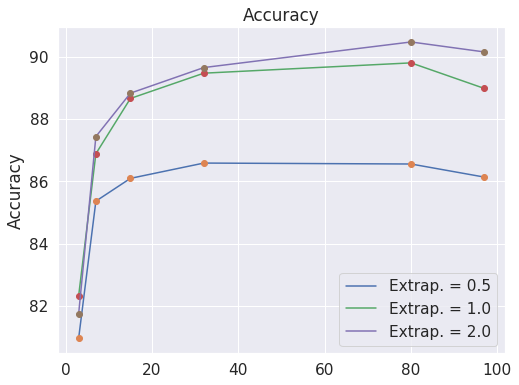

In [20]:
#plot accuracy

print(outcome)

poly=[]
compr=[]
size=[]
extrap_last = -9999
for row in range(0,len(outcome)):
   extrap = outcome[row][0]
   #print(row,outcome[row] )
   if row == 0:
     extrap_last = extrap
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2])
     print(compr, poly)
   elif extrap != extrap_last:
     line, = pyl.plot(compr, poly)
     pyl.plot(compr, poly,"o")
     print("plot ",extrap_last,compr, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)
     poly=[]
     compr=[]
     size=[]
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2])
     extrap_last = extrap
   elif row == len(outcome)-1:
     poly.append(outcome[row][3])
     compr.append(outcome[row][1]) 
     size.append(outcome[row][2]) 
     line, = pyl.plot(compr, poly)
     pyl.plot(compr, poly,"o")
     print("plot ",extrap_last,compr, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)          
   else:
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2])



pyl.legend() 

pyl.title("Accuracy")
auxText = ""
if (jpeg_format == "JPEG2000"):
   auxText == "JPEG200 compression"
elif (jpeg_format == "jpeg"):
   auxText == "jpeg quality"  
pyl.xlabel(auxText)
pyl.ylabel("Accuracy")
pyl.show()


#print("Accuracy: ", acc_scores)
#print("JPEG compression: ", compression_list)


[(0.5, 97, 261112.7, 86.14000082015991, 26.349355850219723), (0.5, 80, 131027.0, 86.55999898910522, 26.792893867492673), (0.5, 32, 65876.2, 86.58999800682068, 28.095047426223758), (0.5, 15, 33518.4, 86.10000014305115, 27.46392412662506), (0.5, 7, 16898.3, 85.36999821662903, 29.5361452460289), (0.5, 3, 7464.4, 80.97000122070312, 37.63397343635559), (1.0, 97, 260939.1, 88.98000121116638, 22.05914992570877), (1.0, 80, 131216.0, 89.80000019073486, 21.740656958818434), (1.0, 32, 65785.9, 89.46999907493591, 20.96896324276924), (1.0, 15, 33405.5, 88.66000175476074, 22.693689181804658), (1.0, 7, 16775.1, 86.89000010490417, 26.465690603256224), (1.0, 3, 7706.3, 82.33000040054321, 34.898497271537785), (2.0, 97, 261122.3, 90.14999866485596, 19.500135575532912), (2.0, 80, 131182.4, 90.4699981212616, 20.241286759376525), (2.0, 32, 65749.7, 89.64999914169312, 20.559979295730592), (2.0, 15, 33627.8, 88.83000016212463, 21.716435432434082), (2.0, 7, 16755.1, 87.44000196456909, 25.016569876670836), (2.0

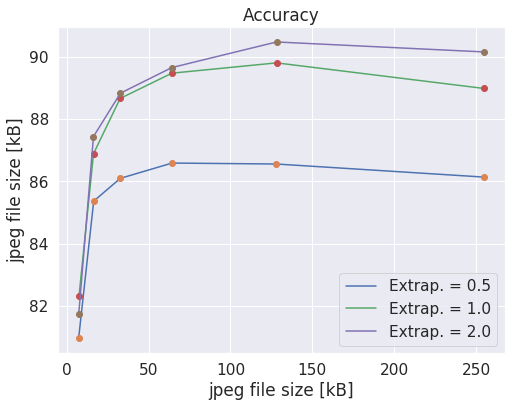

[255.00224609375, 128.1078125, 64.20869140625, 32.8396484375, 16.36240234375, 7.35478515625]
[97, 80, 32, 15, 7, 3]
[90.14999866485596, 90.4699981212616, 89.64999914169312, 88.83000016212463, 87.44000196456909, 81.74999952316284]


In [21]:
#plot accuracy

print(outcome)

poly=[]
compr=[]
size=[]
extrap_last = -9999
for row in range(0,len(outcome)):
   extrap = outcome[row][0]
   #print(row,outcome[row] )
   if row == 0:
     extrap_last = extrap
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2]/1024.)
     #print(size, poly)
   elif extrap != extrap_last:
     line, = pyl.plot(size, poly)
     pyl.plot(size, poly,"o")
     #print("plot ",extrap_last,size, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)
     poly=[]
     compr=[]
     size=[]
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2]/1024.)
     extrap_last = extrap
   elif row == len(outcome)-1:
     poly.append(outcome[row][3])
     compr.append(outcome[row][1]) 
     size.append(outcome[row][2]/1024.) 
     line, = pyl.plot(size, poly)
     pyl.plot(size, poly,"o")
     #print("plot ",extrap_last,size, poly)
     label = "Extrap. = "+str(extrap_last)
     line.set_label(label)          
   else:
     poly.append(outcome[row][3])
     compr.append(outcome[row][1])
     size.append(outcome[row][2]/1024.)



pyl.legend() 

pyl.title("Accuracy")
auxText = jpeg_format+" file size [kB]"
pyl.xlabel(auxText)
pyl.ylabel(auxText)
pyl.show()

print(size)
print(compr)
print(poly)
#print("Accuracy: ", acc_scores)
#print("JPEG compression: ", compression_list)


In [22]:
#plot loss
#pyl.plot(jpeg_compression_list, loss_scores)
#pyl.plot(jpeg_compression_list, loss_scores,'o')
#pyl.title("Loss")
#pyl.xlabel("JPEG quality")
#pyl.ylabel("Loss")
#pyl.show()